## **-- PREPARATION --**

In [5]:
import numpy as np  # for array
import pandas as pd  # for csv files and dataframe
import glob

import matplotlib.pyplot as plt  # for plotting
import seaborn as sns  # plotting
from scipy import stats

import pickle  # To load data int disk

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer
from sklearn.metrics import auc, f1_score, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_validate, cross_val_predict

In [6]:
train = pd.read_csv(r'H:\CYBERSENTINEL\ML\cybersentinel.csv', encoding='ISO-8859-1')

Les données contiennent plusieurs colonnes, dont certaines sont des caractéristiques des paquets réseau et d'autres semblent être des métadonnées ou des statistiques dérivées.
Les colonnes comme srcip, dstip, sport, et dsport sont essentielles pour identifier la source et la destination du trafic.
Les colonnes liées à la durée, au débit, à la taille des paquets et aux paquets perdus peuvent fournir des informations sur la qualité et la nature du trafic.
Les colonnes comme state, service, proto et attack_cat peuvent aider à catégoriser le trafic.
Les colonnes comme tcprtt, synack, et ackdat sont importantes pour l'analyse du trafic TCP.
Les colonnes Label et attack_cat sont essentielles pour l'analyse des intrusions et la détection des attaques.

- srcip, dstip: Adresses IP source et destination. Ce sont des informations clés pour identifier d'où proviennent les données et où elles vont.

- sport, dsport: Ports source et destination. Ils sont essentiels pour identifier quel service ou application est utilisé dans une transaction.

- proto: Protocole de transaction. Cette information est utile pour classer le type de trafic.

- state: Indique l'état de la connexion, ce qui peut aider à identifier des comportements anormaux.

- dur: Durée de la connexion. Les connexions très courtes ou très longues peuvent être suspectes.

- sbytes, dbytes: Quantité de données envoyées et reçues. Une grande quantité de données peut indiquer un transfert de données important, comme un téléchargement.

- sttl, dttl: Time to Live des paquets. Des valeurs anormales peuvent indiquer des tentatives de masquage de trafic.

- sloss, dloss: Paquets perdus. Une grande perte de paquets peut indiquer un réseau de mauvaise qualité ou des attaques.

- service: Type de service utilisé. Certains services sont plus souvent ciblés par des attaques.

- Sload, Dload: Débit du réseau. Un débit anormalement élevé ou faible peut être suspect.

- Spkts, Dpkts: Nombre de paquets envoyés et reçus.

- swin, dwin: Valeurs de la fenêtre TCP. Des valeurs anormales peuvent indiquer des tentatives d'attaque.

- stcpb, dtcpb: Numéros de séquence TCP. Ils sont importants pour l'analyse du trafic TCP.

- smeansz, dmeansz: Taille moyenne des paquets.

- trans_depth: Profondeur de la transaction HTTP.

- res_bdy_len: Taille du contenu HTTP.

- Sjit, Djit: Jitter source et destination. Le jitter peut indiquer des problèmes de réseau.

- Stime, Ltime: Temps de début et de fin de l'enregistrement.

- Sintpkt, Dintpkt: Temps entre paquets.

- tcprtt, synack, ackdat: Temps de configuration de la connexion TCP.

- is_sm_ips_ports: Indique si l'adresse IP source et destination ainsi que les ports sont identiques.

- ct_state_ttl, ct_flw_http_mthd, is_ftp_login, ct_ftp_cmd, ct_srv_src, ct_srv_dst, ct_dst_ltm, ct_src_ ltm, ct_src_dport_ltm, ct_dst_sport_ltm, ct_dst_src_ltm: Ces colonnes fournissent des informations sur le comportement et les motifs des connexions.

- attack_cat: Catégorie d'attaque. C'est une information essentielle pour classer et identifier le type d'attaque.

- Label: Étiquette indiquant si c'est une attaque ou non.

## **-- NETTOYAGE --**

3.   Examiner la distribution des types de données.
4.   Examiner les valeurs uniques pour les colonnes catégorielles et convertir les caractéristiques catégorielles en numériques (par exemple, "proto", "state").
5.   Normaliser les caractéristiques numériques.




### Distribution des types de données

In [13]:
data_types_distribution = train.dtypes.value_counts()

data_types_distribution

int64      28
float64    11
object      9
int32       1
Name: count, dtype: int64

Vérifications des colonnes binaires :

In [14]:
# Check unique values in the 'is_sm_ips_ports' column
unique_values_is_sm_ips_ports = train['is_sm_ips_ports'].unique()

unique_values_is_sm_ips_ports

array([0, 1], dtype=int64)

In [15]:
# Check unique values in the 'label' column
unique_values_label = train['label'].unique()

unique_values_label

array([0, 1], dtype=int64)

Le bug est ici : 4 valeurs au lieu de 2

In [16]:
# Check unique values in the 'is_ftp_login' column
unique_values_is_ftp_login = train['is_ftp_login'].unique()

unique_values_is_ftp_login

array([0, 1, 4, 2])

In [17]:
filtered_rows = train[train['is_ftp_login'].isin([2, 4])]
filtered_rows

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
701685,59.166.0.6,18576,149.171.126.4,21,tcp,FIN,1.247383,2934,3742,31,...,4,3,2,7,12,2,2,5,normal,0
703434,59.166.0.3,44530,149.171.126.5,21,tcp,FIN,0.031594,2934,3742,31,...,4,2,2,7,10,2,2,6,normal,0
703645,59.166.0.7,15837,149.171.126.1,21,tcp,FIN,0.844451,2934,3742,31,...,4,2,2,3,4,2,2,5,normal,0
721336,59.166.0.1,12976,149.171.126.7,21,tcp,FIN,2.235698,2934,3742,31,...,4,1,1,5,1,1,1,4,normal,0
721338,59.166.0.1,12976,149.171.126.7,21,tcp,FIN,2.235698,2934,3742,31,...,4,1,1,9,4,1,1,5,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2491755,59.166.0.4,1202,149.171.126.1,21,tcp,FIN,0.023019,2934,3740,31,...,4,2,2,7,11,2,2,7,normal,0
2497703,59.166.0.5,4592,149.171.126.1,21,tcp,FIN,2.615758,2934,3740,31,...,4,2,2,3,6,2,2,4,normal,0
2526646,59.166.0.7,10115,149.171.126.3,21,tcp,FIN,1.293708,2934,3740,31,...,4,2,2,6,8,2,2,5,normal,0
2530008,59.166.0.4,54752,149.171.126.8,21,tcp,FIN,0.023605,2934,3742,31,...,4,2,2,6,6,2,2,5,normal,0


In [18]:
filtered_rows = train[(train['is_ftp_login'].isin([2, 4])) & (train['label'] == 1)]
filtered_rows

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
1611324,175.45.176.1,56910,149.171.126.16,21,tcp,CON,1.564220,690,940,62,...,4,2,2,2,5,2,2,2,exploits,1
1611343,175.45.176.1,56910,149.171.126.16,21,tcp,CON,1.564220,690,940,62,...,4,2,2,2,5,2,2,2,exploits,1
1611350,175.45.176.1,56910,149.171.126.16,21,tcp,CON,1.564220,690,940,62,...,4,2,2,2,5,2,2,2,exploits,1
1611405,175.45.176.1,56910,149.171.126.16,21,tcp,CON,1.564220,690,940,62,...,4,2,2,2,5,2,2,2,exploits,1
1611494,175.45.176.1,56910,149.171.126.16,21,tcp,FIN,0.742644,578,690,62,...,4,2,2,3,8,2,2,3,exploits,1
1611511,175.45.176.1,56910,149.171.126.16,21,tcp,FIN,0.742644,578,690,62,...,4,2,2,3,8,2,2,3,exploits,1
1611565,175.45.176.1,56910,149.171.126.16,21,tcp,FIN,0.742644,578,690,62,...,4,2,2,3,8,2,2,3,exploits,1
1611594,175.45.176.1,56910,149.171.126.16,21,tcp,FIN,0.742644,578,690,62,...,4,2,2,3,8,2,2,3,exploits,1
1761433,175.45.176.3,9670,149.171.126.12,21,tcp,CON,2.349103,690,1038,62,...,4,2,2,2,2,2,2,2,exploits,1
1761434,175.45.176.3,9670,149.171.126.12,21,tcp,CON,2.349103,690,1038,62,...,4,2,2,2,2,2,2,2,exploits,1


Toutes ces entrées sont associées au port 21, qui est le port FTP standard.
La colonne attack_cat indique "normal" et "activités malveillantes".

Peut-être que 2 et 4 sont des codes pour des types spécifiques de sessions FTP ou de commandes FTP (par exemple, 2 pourrait signifier une tentative d'authentification FTP échouée et 4 pourrait signifier une tentative d'authentification FTP réussie avec des commandes malveillantes : pas seulement)? Si ces valeurs ont une signification pertinente pour l'analyse ou le modèle, on peut choisir de les conserver et de traiter la colonne comme une variable catégorielle.

Si elles n'ont pas de signification ou si elles perturbent l'analyse, on les traite comme port FTP standard = 1.

Analyse supplémentaire : Examiner d'autres caractéristiques de ces lignes pour voir si elles présentent des schémas particuliers. Par exemple, y a-t-il d'autres colonnes qui ont des valeurs inhabituelles pour ces lignes ?

### Valeurs uniques pour les colonnes catégorielles

Pour comprendre les données et pour la préparation des données pour le machine learning.

In [19]:
# Check unique values for categorical columns
categorical_columns = train.select_dtypes(include=['object']).columns
unique_values_categorical = {col: train[col].unique() for col in categorical_columns}

unique_values_categorical

{'srcip': array(['59.166.0.0', '59.166.0.6', '59.166.0.5', '59.166.0.3',
        '10.40.182.3', '59.166.0.7', '10.40.170.2', '59.166.0.1',
        '59.166.0.2', '59.166.0.4', '175.45.176.3', '175.45.176.2',
        '175.45.176.0', '59.166.0.8', '59.166.0.9', '175.45.176.1',
        '10.40.182.1', '10.40.85.1', '192.168.241.243', '10.40.85.30',
        '149.171.126.16', '149.171.126.2', '149.171.126.11',
        '149.171.126.4', '149.171.126.5', '149.171.126.17',
        '149.171.126.19', '149.171.126.9', '149.171.126.8',
        '149.171.126.7', '149.171.126.15', '149.171.126.6',
        '149.171.126.0', '149.171.126.1', '149.171.126.3',
        '149.171.126.13', '149.171.126.12', '149.171.126.10',
        '149.171.126.18', '127.0.0.1', '10.40.85.10', '10.40.182.6',
        '149.171.126.14'], dtype=object),
 'sport': array([33661, 1464, 3593, ..., 74, 351, 190], dtype=object),
 'dstip': array(['149.171.126.9', '149.171.126.7', '149.171.126.5', '149.171.126.0',
        '149.171.126.4', 

srcip et dstip : Ces colonnes contiennent des adresses IP. Elles semblent propres et sans valeurs aberrantes à première vue.

proto : Cette colonne contient différents protocoles de communication. Les valeurs semblent appropriées. La plupart du trafic utilise les protocoles tcp et udp, qui sont les protocoles les plus courants pour le trafic Internet. Il y a 65 protocoles uniques dans cet ensemble de données, mais beaucoup d'entre eux ont un faible nombre d'occurrences.

state (état de connexion): Les valeurs dans cette colonne indiquent l'état de la connexion. Les valeurs semblent également appropriées. La majorité des connexions sont dans l'état FIN (terminé) ou CON (établi).

service : Cette colonne identifie le service utilisé (par exemple, HTTP, DNS). Il y a une valeur '-' qui pourrait représenter des données manquantes ou inconnues.

ct_ftp_cmd : Cette colonne semble contenir des valeurs numériques, bien qu'elle soit traitée comme catégorielle. Il serait judicieux de vérifier si elle devrait être convertie en type numérique.

attack_cat : Cette colonne identifie la catégorie d'attaque. Les valeurs semblent appropriées.



## -- VISUALISATION --

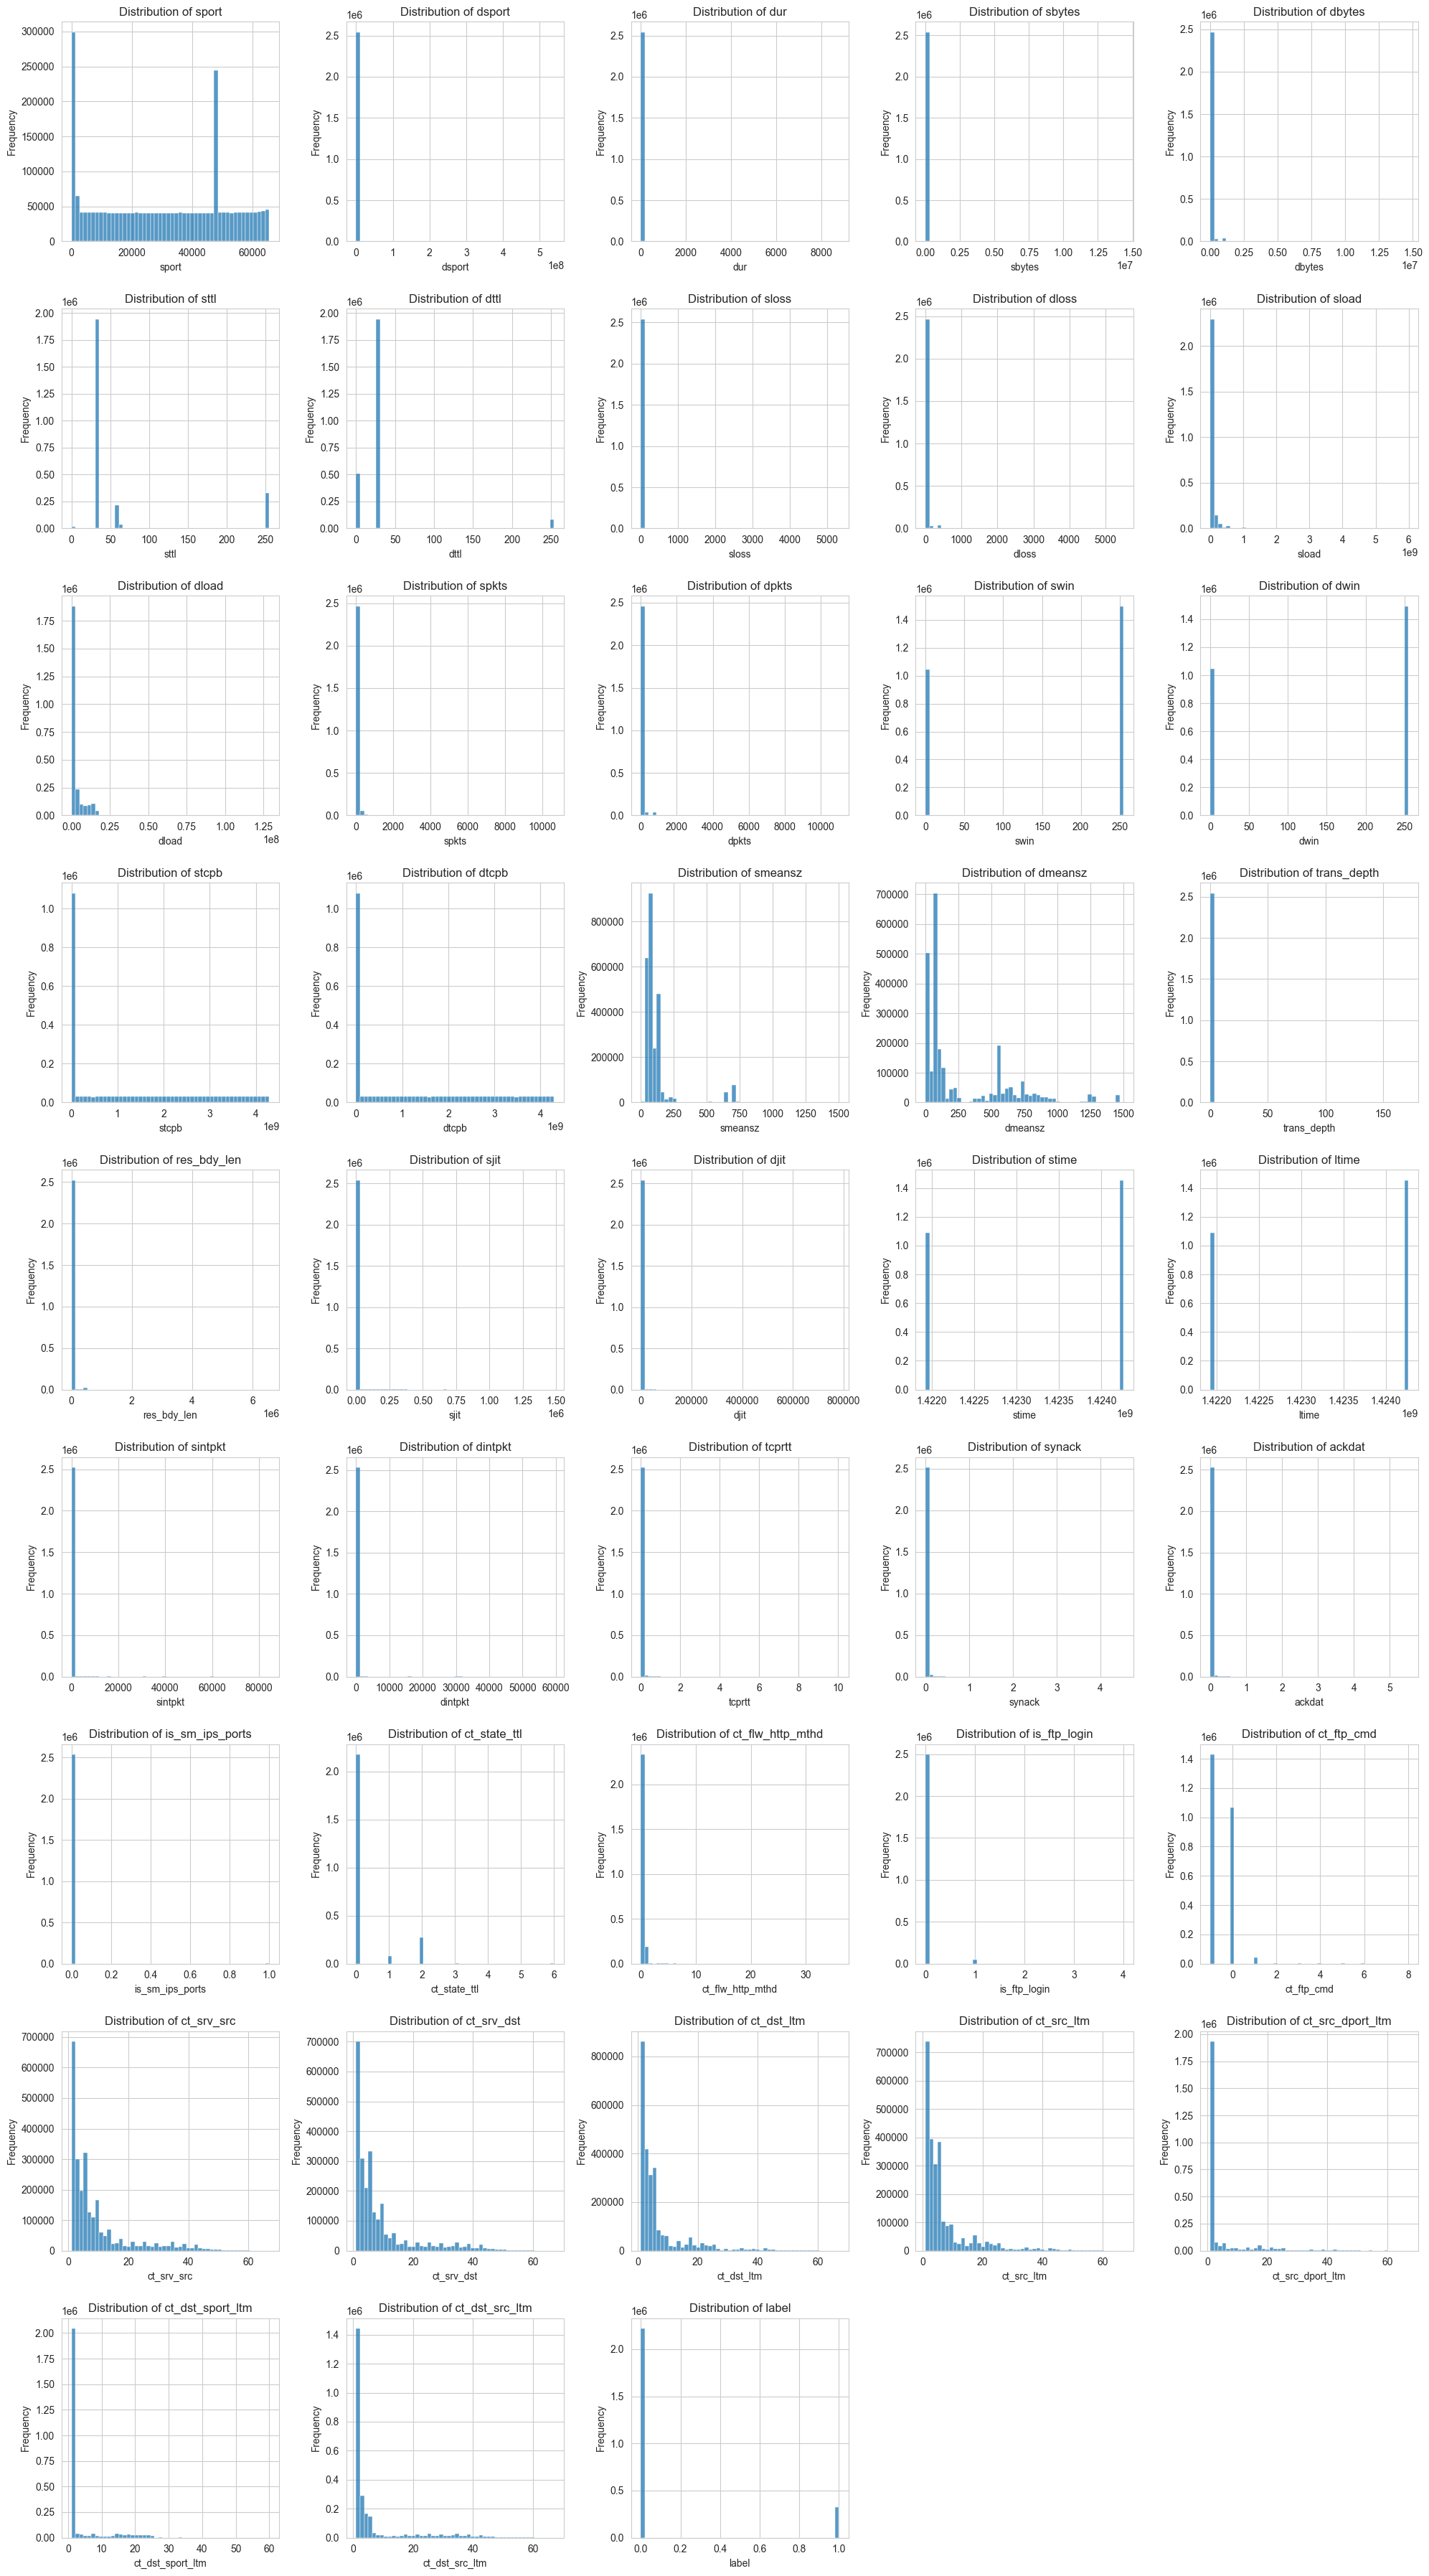

In [7]:
# Set style for seaborn plots
sns.set_style("whitegrid")

# Identify numerical and categorical columns
numerical_cols = train.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = train.select_dtypes(include=['object']).columns

# Determine the number of rows needed for the plots
num_rows = len(numerical_cols) // 5
if len(numerical_cols) % 5:
    num_rows += 1

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, 5, figsize=(20, num_rows*4))

# Flatten the axes array
axs = axs.flatten()

# Plotting histograms for numerical columns
for i, col in enumerate(numerical_cols):
    sns.histplot(train[col], bins=50, kde=False, ax=axs[i])
    axs[i].set_title(f'Distribution of {col}')
    axs[i].set_ylabel('Frequency')
    axs[i].set_xlabel(col)

# Remove the unused subplots
if len(numerical_cols) < len(axs):
    for i in range(len(numerical_cols), len(axs)):
        fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

### Visualisation de la distribution des catégories d'attaques, des protocoles, des états de connexion, de certaines caractéristiques numériques

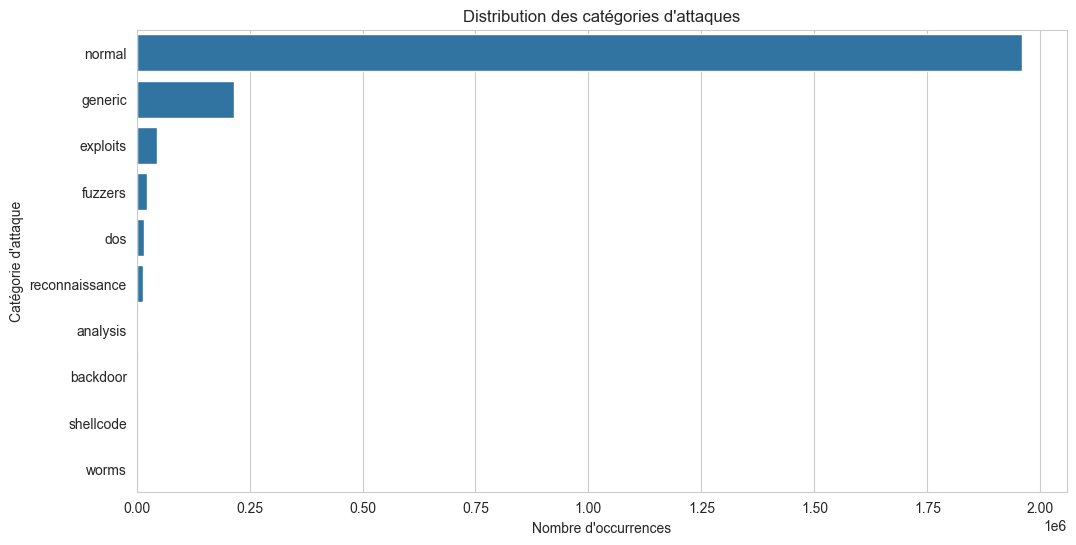

In [20]:
# Paramètres de style
sns.set_style("whitegrid")

# Visualisation de la distribution des catégories d'attaques
plt.figure(figsize=(12, 6))
sns.countplot(y=train['attack_cat'], order=train['attack_cat'].value_counts().index)
plt.title("Distribution des catégories d'attaques")
plt.xlabel("Nombre d'occurrences")
plt.ylabel("Catégorie d'attaque")
plt.show()

9 familles d'attaques :

Fuzzers : attaque qui utilise des quantités massives de données aléatoires appelées « Fuzz » pour déclencher une panne d'un réseau ou tenter de faire planter des serveurs importants sur un réseau.

Analyse : cette classe contient diverses formes d'attaques basées sur des analyses de ports, des analyses de vulnérabilités, des fichiers spam et des empreintes. On l'appelle également reconnaissance active, où le réseau est analysé d'une manière ou d'une autre mais non exploité.

Portes dérobées : cette catégorie utilise une technique par laquelle les attaquants utilisent un portail système légitime pour obtenir un accès illicite. Les portes dérobées utilisent des logiciels malveillants pour s'installer dans un système informatique et pour fournir un accès à distance aux attaquants dans le cadre d'un exploit.

Déni de service (DoS) : cyberattaque bien connue dans laquelle l'auteur cherche à compromettre une machine avec plusieurs demandes de connexion illégitimes afin de rendre les ressources réseau indisponibles pour ses utilisateurs prévus, temporairement ou définitivement. Celles-ci peuvent être difficiles à distinguer d’une activité réseau légitime ; cependant, il existe certains indicateurs permettant de détecter de telles activités intrusives en cours.

Exploits : les attaques par exploit sont généralement réalisées en ciblant et en compromettant les vulnérabilités connues qui existent dans les systèmes d'exploitation. Un logiciel d'exploitation peut également être utilisé pour automatiser ces attaques une fois qu'une vulnérabilité potentielle est détectée dans un réseau.

Générique : Une attaque basée sur des chiffrements, qui est essentiellement une attaque par collision sur la clé secrète générée par les principes cryptographiques. Cette analyse peut être appliquée aux chiffrements de codes d’authentification par blocs, flux et messages. On parle souvent d'attaque par collision, car la plupart de ces familles sont vulnérables à l'attaque d'anniversaire. L'attaque dépend de la probabilité plus élevée de collisions constatées entre les tentatives d'attaque aléatoires.

Reconnaissance : elle collecte des informations préliminaires sur tout réseau public ou hôte cible et est ensuite utilisée par des techniques d'exploitation pour pénétrer les hôtes ou réseaux cibles en exploitant les informations recueillies. Cette classe utilise des informations librement accessibles au service public « Whois », aux enregistrements ARIN et Shodan. Les recherches sur les réseaux sociaux facilitent les attaques de reconnaissance. On les appelle également reconnaissance passive.

Shellcode : Il s’agit d’un sous-ensemble de l’exploit de classe. Cette attaque utilise un petit morceau de code comme charge utile d'un exploit. Le code malveillant est injecté dans une application active pour compromettre et accéder à distance à l'ordinateur d'une victime. Il démarre généralement un shell de commande à partir duquel l'attaquant peut contrôler la machine compromise.

Vers : un ver est une attaque malveillante qui se propage via la propagation du réseau et infecte assez rapidement un réseau beaucoup plus vaste. Un ver peut également infecter des ordinateurs, puis les transformer en zombies ou en robots, dans le but de les utiliser dans des attaques distribuées via la formation de réseaux de zombies.

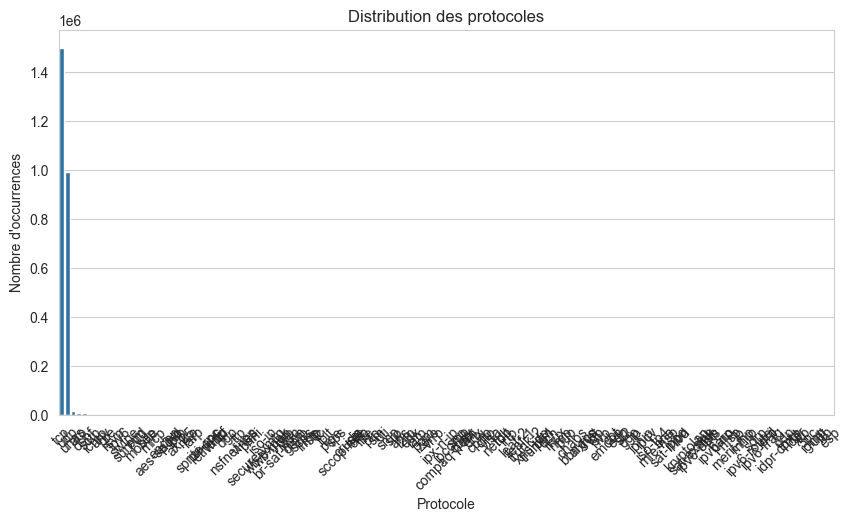

In [51]:
# Visualisation de la distribution des protocoles
plt.figure(figsize=(10, 5))
sns.countplot(x=train['proto'], order=train['proto'].value_counts().index)
plt.title("Distribution des protocoles")
plt.xlabel("Protocole")
plt.ylabel("Nombre d'occurrences")
plt.xticks(rotation=45)
plt.show()

La visualisation montre que le protocole tcp est le plus couramment utilisé, suivi de udp et unas. Les autres protocoles ont un nombre nettement plus faible d'occurrences.

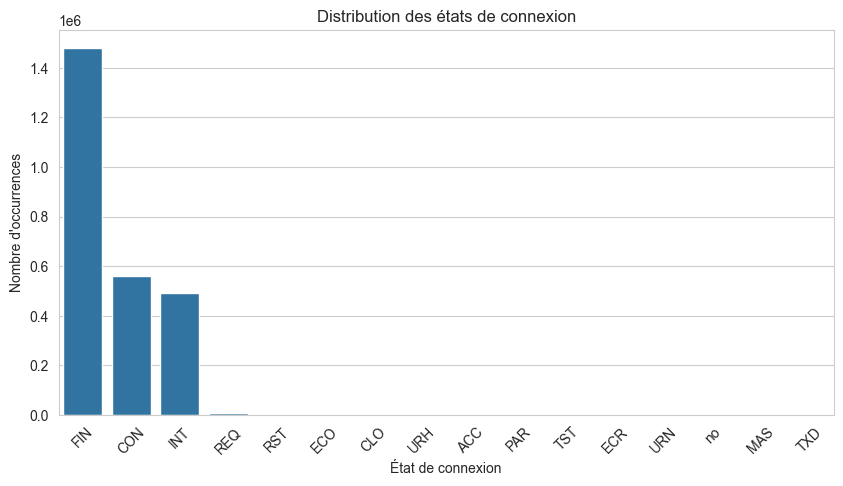

In [52]:
# Visualisation de la distribution des états de connexion
plt.figure(figsize=(10, 5))
sns.countplot(x=train['state'], order=train['state'].value_counts().index)
plt.title("Distribution des états de connexion")
plt.xlabel("État de connexion")
plt.ylabel("Nombre d'occurrences")
plt.xticks(rotation=45)
plt.show()

La visualisation montre que l'état FIN est le plus courant, suivi de INT. Les autres états ont un nombre d'occurrences beaucoup plus faible.

L'état FIN signifie généralement que la connexion a été établie et terminée normalement, tandis que INT peut indiquer des connexions interrompues ou non initialisées.

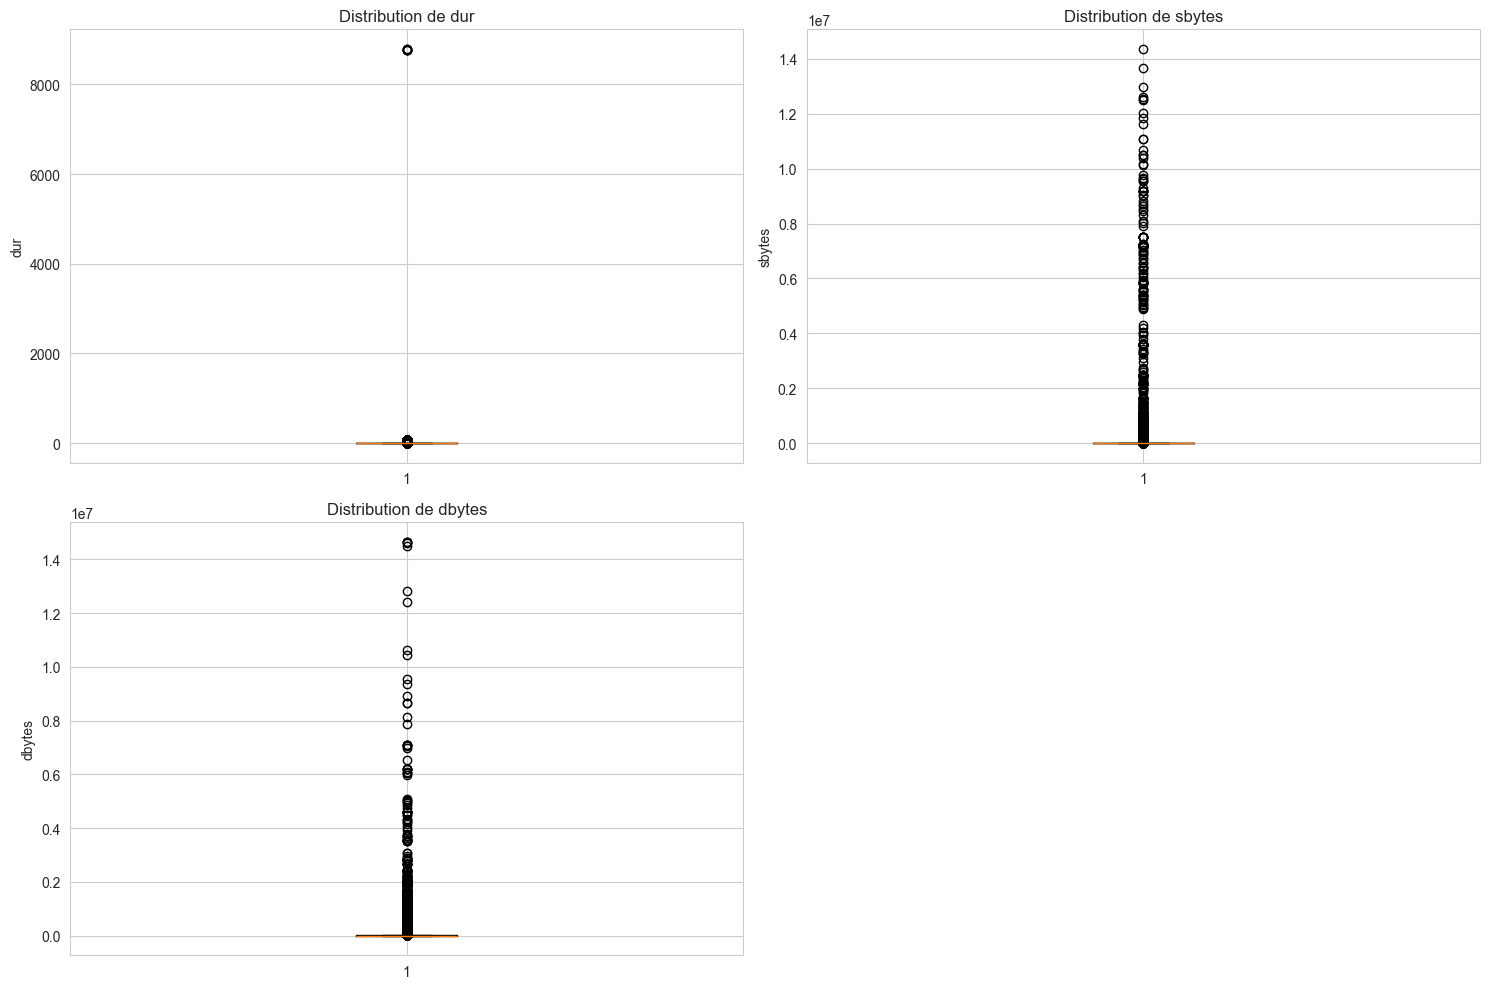

In [53]:
# Visualisation de la distribution de certaines caractéristiques numériques
features_to_plot = ['dur', 'sbytes', 'dbytes']

plt.figure(figsize=(15, 10))

for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 2, i)
    plt.boxplot(train[feature])
    plt.title(f'Distribution de {feature}')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

1.   dur (durée): La plupart des valeurs sont concentrées autour de valeurs faibles, mais il y a quelques points qui s'écartent de la distribution principale. Ces points pourraient être considérés comme des valeurs aberrantes.
2.   sbytes (octets envoyés): De même, la plupart des valeurs sont concentrées autour de valeurs faibles, mais il y a quelques valeurs qui sont nettement plus élevées.
3.   dbytes (octets reçus): La situation est similaire à celle de sbytes.









1.   Prétraitement : Les colonnes contenant des données non numériques (comme proto, state, etc.) doivent être encodées pour être utilisées dans la modélisation.
2.   Division des données : Nous diviserons les données en ensembles d'entraînement et de test.

### Relation entre les protocoles et les types d'attaque

In [54]:
# Relation entre proto et attack_cat
protocol_attack_relation = pd.crosstab(train['proto'], train['attack_cat'])

# Trier par types d'attaques les plus courantes pour une meilleure visibilité
sorted_columns = protocol_attack_relation.sum().sort_values(ascending=False).index
protocol_attack_relation = protocol_attack_relation[sorted_columns]


protocol_attack_relation

attack_cat,normal,generic,exploits,fuzzers,dos,reconnaissance,analysis,backdoor,shellcode,worms
proto,,,,,,,,,,
3pc,0,6,55,10,44,7,8,7,0,0
a/n,0,6,55,10,44,7,8,7,0,0
aes-sp3-d,0,6,55,10,44,7,8,7,0,0
any,0,18,165,30,132,21,24,21,0,0
argus,0,6,55,10,44,7,8,7,0,0
...,...,...,...,...,...,...,...,...,...,...
wsn,0,6,55,10,44,7,8,7,0,0
xnet,0,6,55,10,44,7,8,7,0,0
xns-idp,0,6,55,10,44,7,8,7,0,0


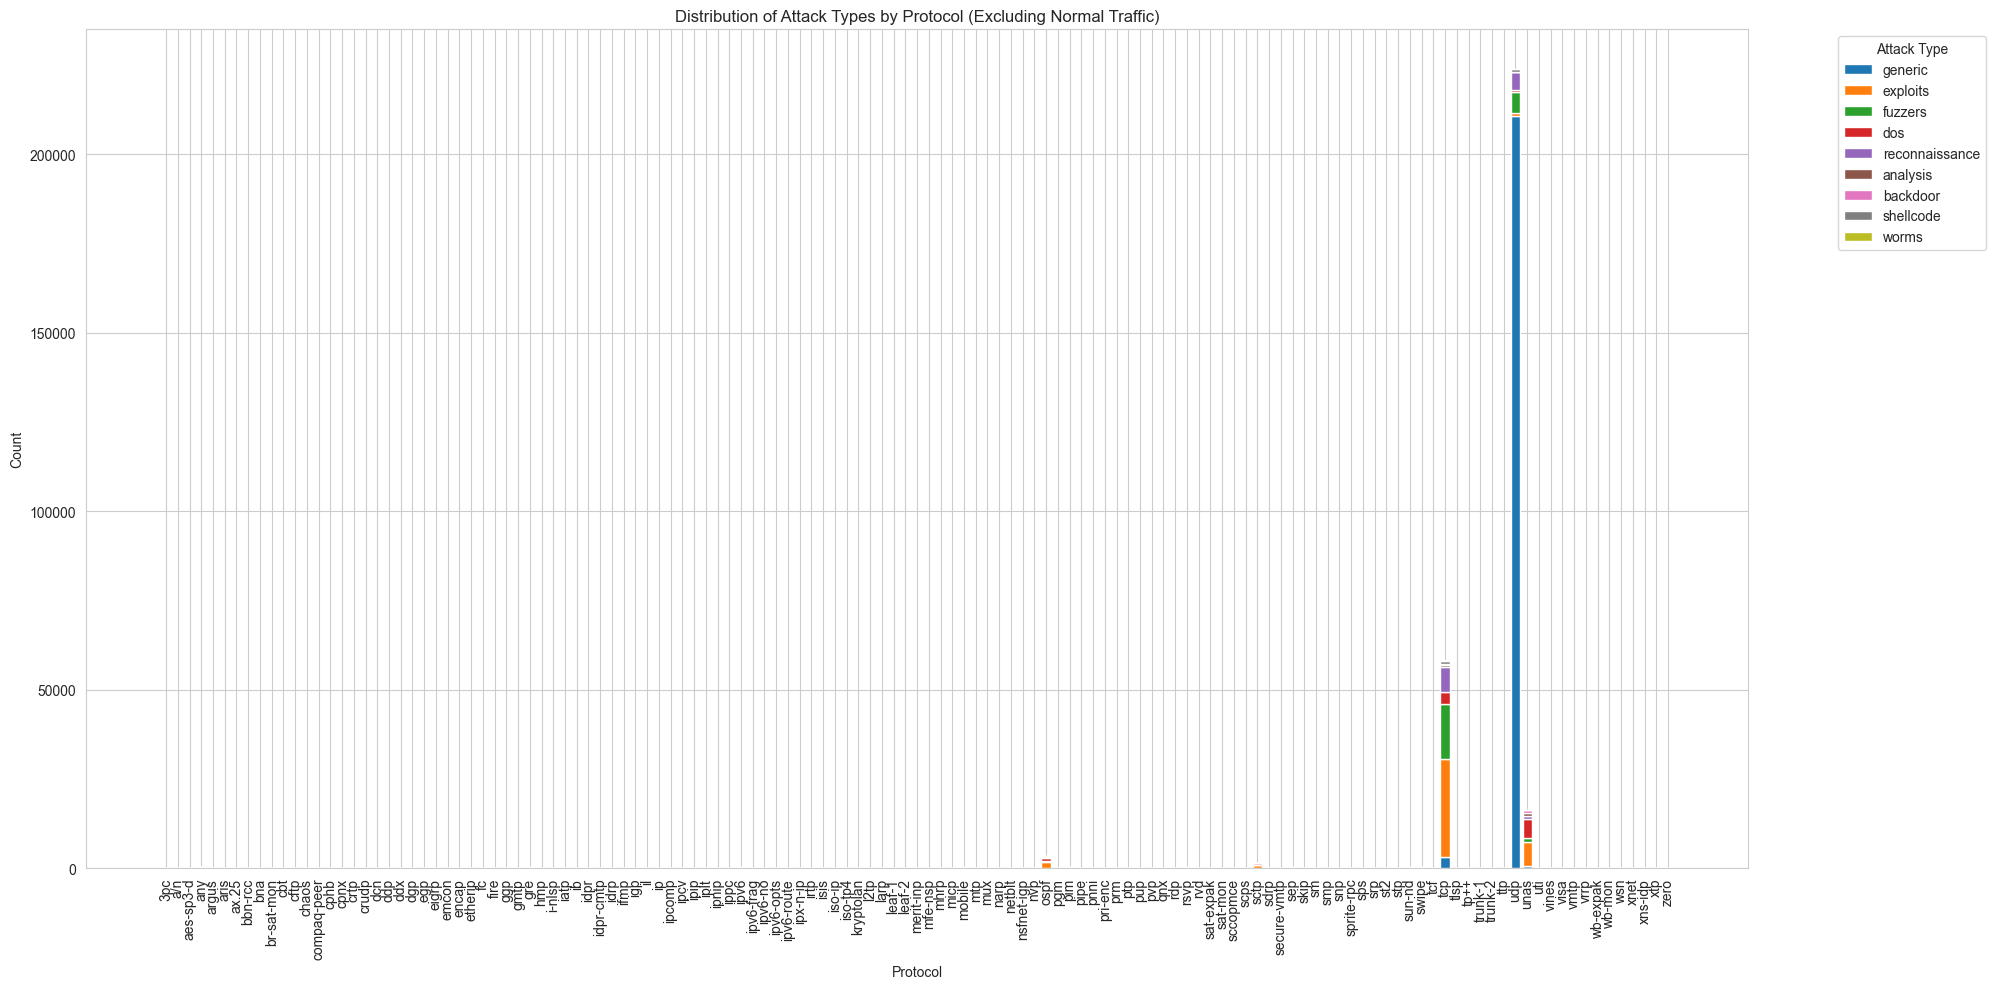

In [55]:
# Remove 'normal' column
protocol_attack_relation_filtered = protocol_attack_relation.drop(columns=['normal'])

# Filter out protocols that only have 'normal' traffic
protocol_attack_relation_filtered = protocol_attack_relation_filtered[protocol_attack_relation_filtered.sum(axis=1) > 0]

# Set up the figure and axis
plt.figure(figsize=(20, 10))
ax = plt.subplot(111)

# Data for stacked bar plot
bottom = np.zeros(len(protocol_attack_relation_filtered))

# Plot each attack type as a segment of the stacked bar
for column in protocol_attack_relation_filtered.columns:
    ax.bar(protocol_attack_relation_filtered.index, protocol_attack_relation_filtered[column], label=column, bottom=bottom)
    bottom += protocol_attack_relation_filtered[column]

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)

# Labeling and showing the plot
plt.title("Distribution of Attack Types by Protocol (Excluding Normal Traffic)")
plt.xlabel("Protocol")
plt.ylabel("Count")
plt.legend(title="Attack Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

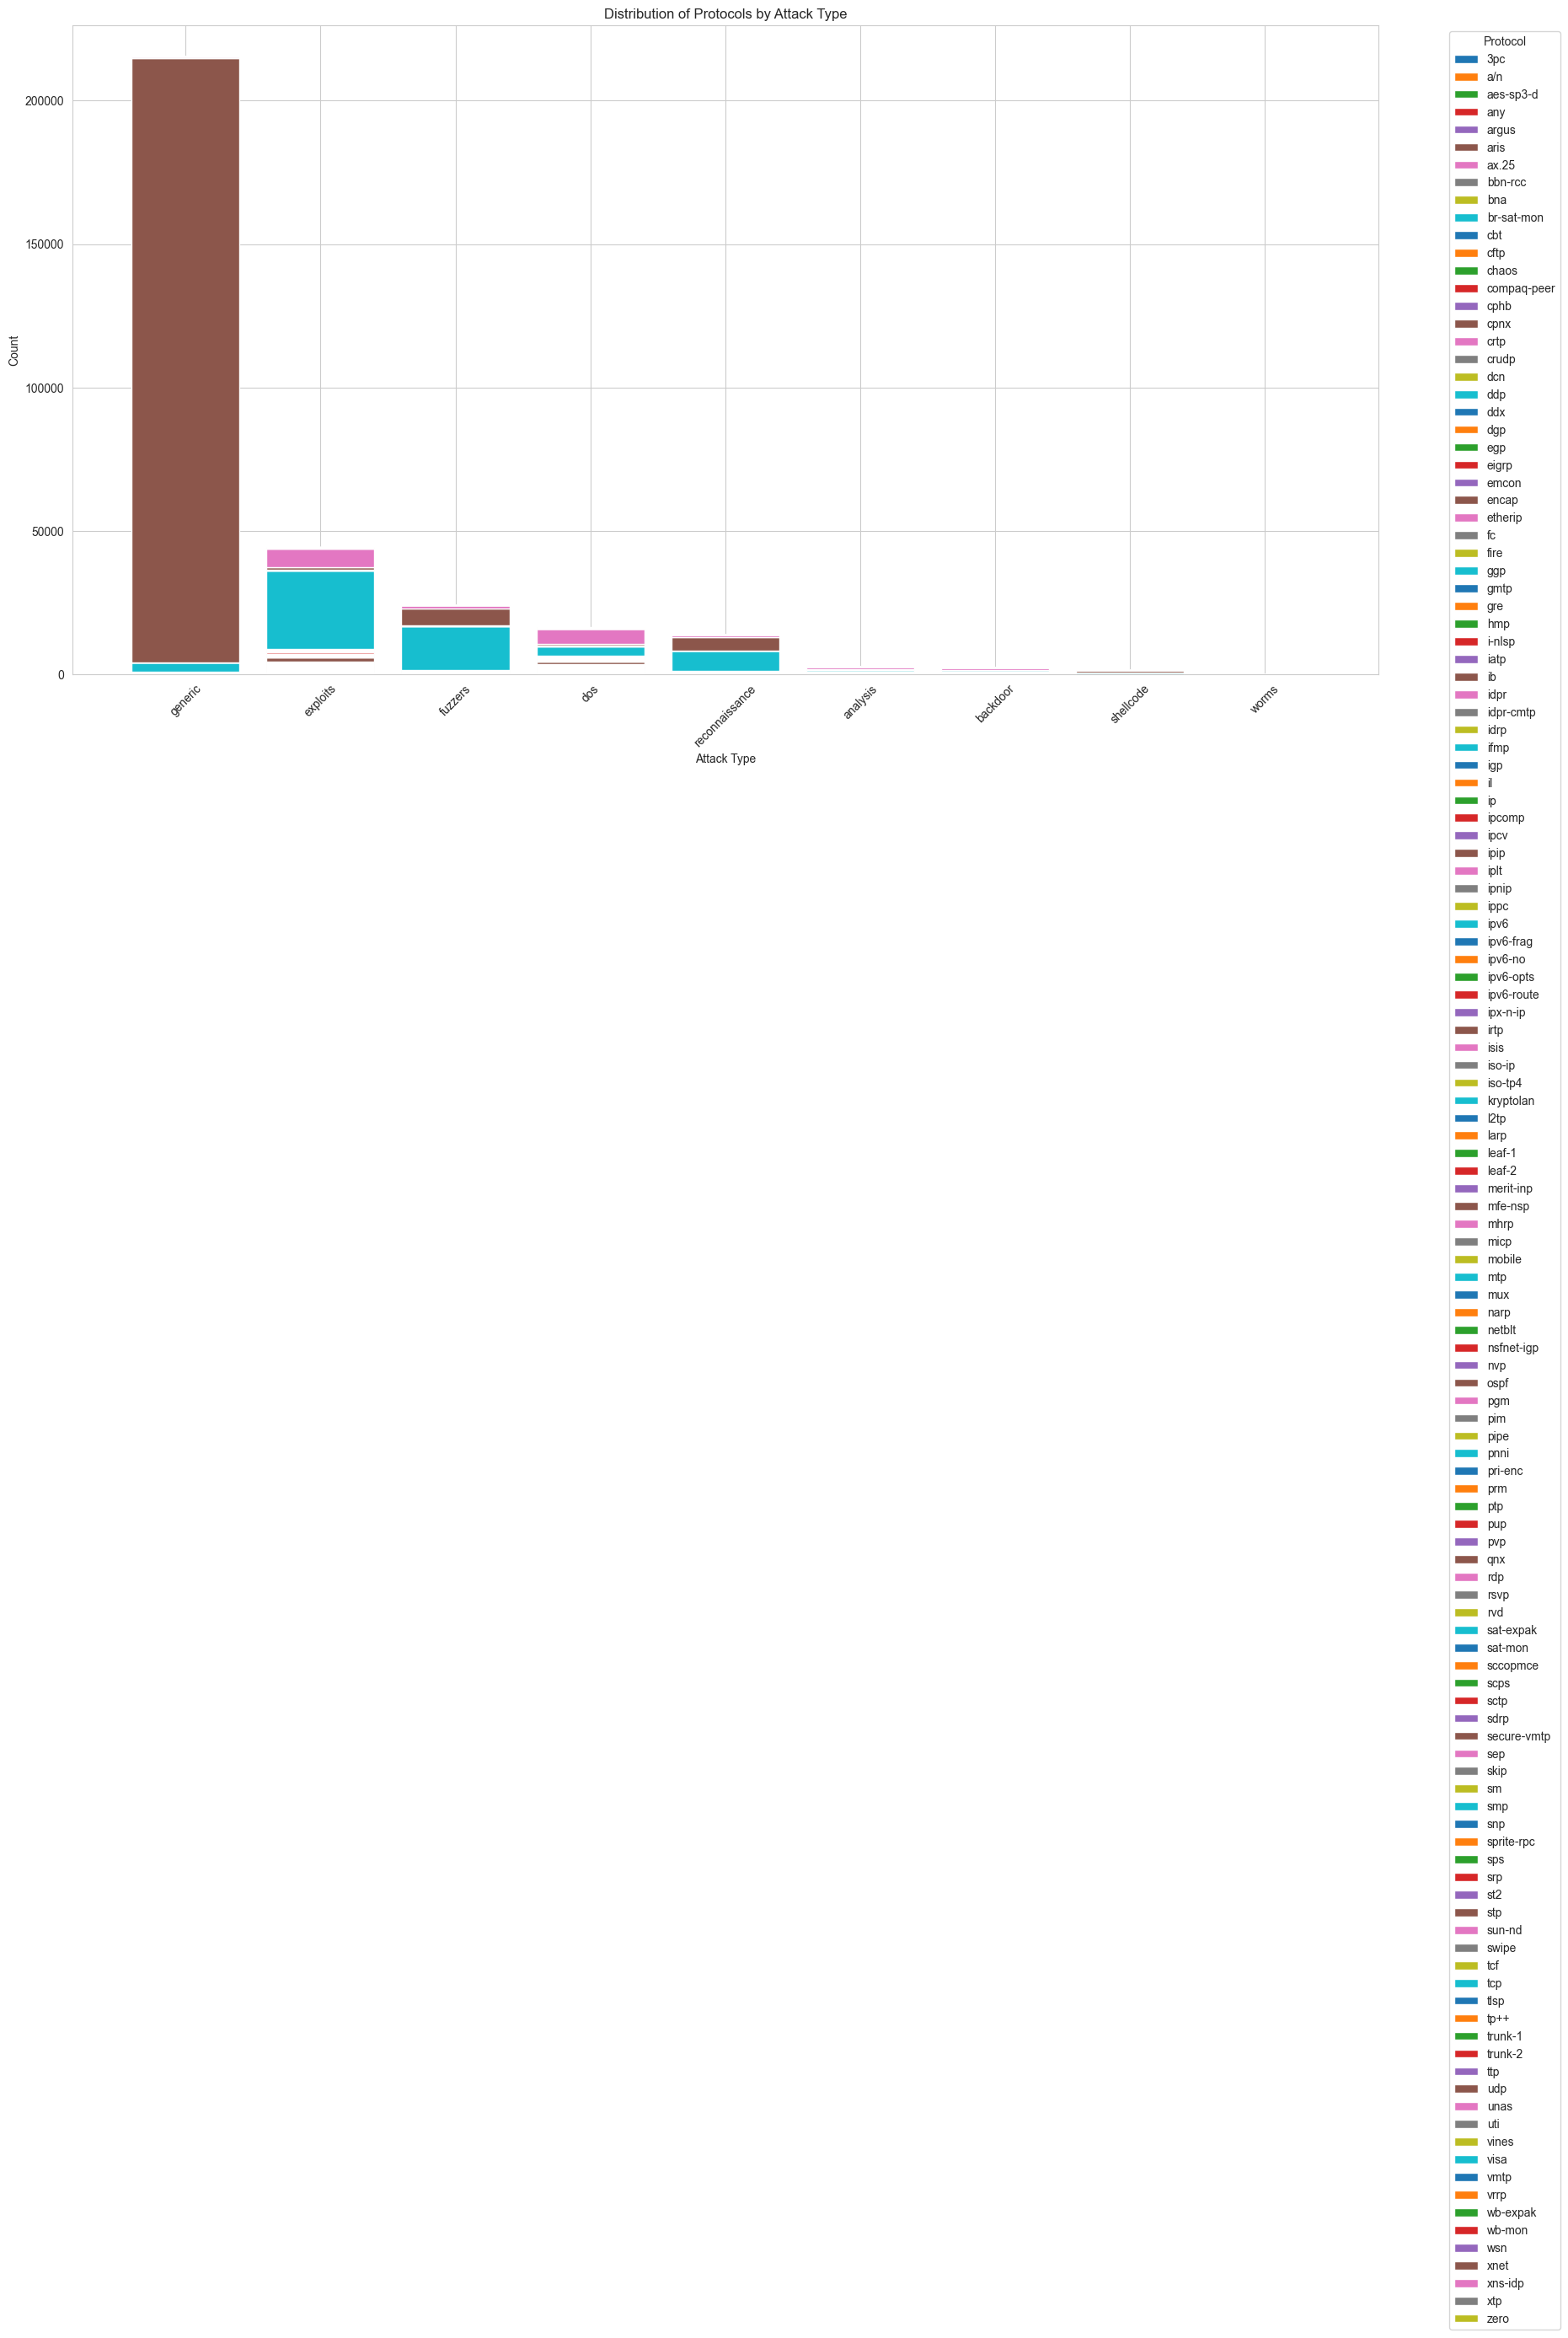

In [56]:
# Transpose the dataframe for plotting
protocol_attack_transposed = protocol_attack_relation_filtered.transpose()

# Set up the figure and axis
plt.figure(figsize=(20, 10))
ax = plt.subplot(111)

# Data for stacked bar plot
bottom = np.zeros(len(protocol_attack_transposed))

# Plot each attack type as a segment of the stacked bar
for column in protocol_attack_transposed.columns:
    ax.bar(protocol_attack_transposed.index, protocol_attack_transposed[column], label=column, bottom=bottom)
    bottom += protocol_attack_transposed[column]

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Labeling and showing the plot
plt.title("Distribution of Protocols by Attack Type")
plt.xlabel("Attack Type")
plt.ylabel("Count")
plt.legend(title="Protocol", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

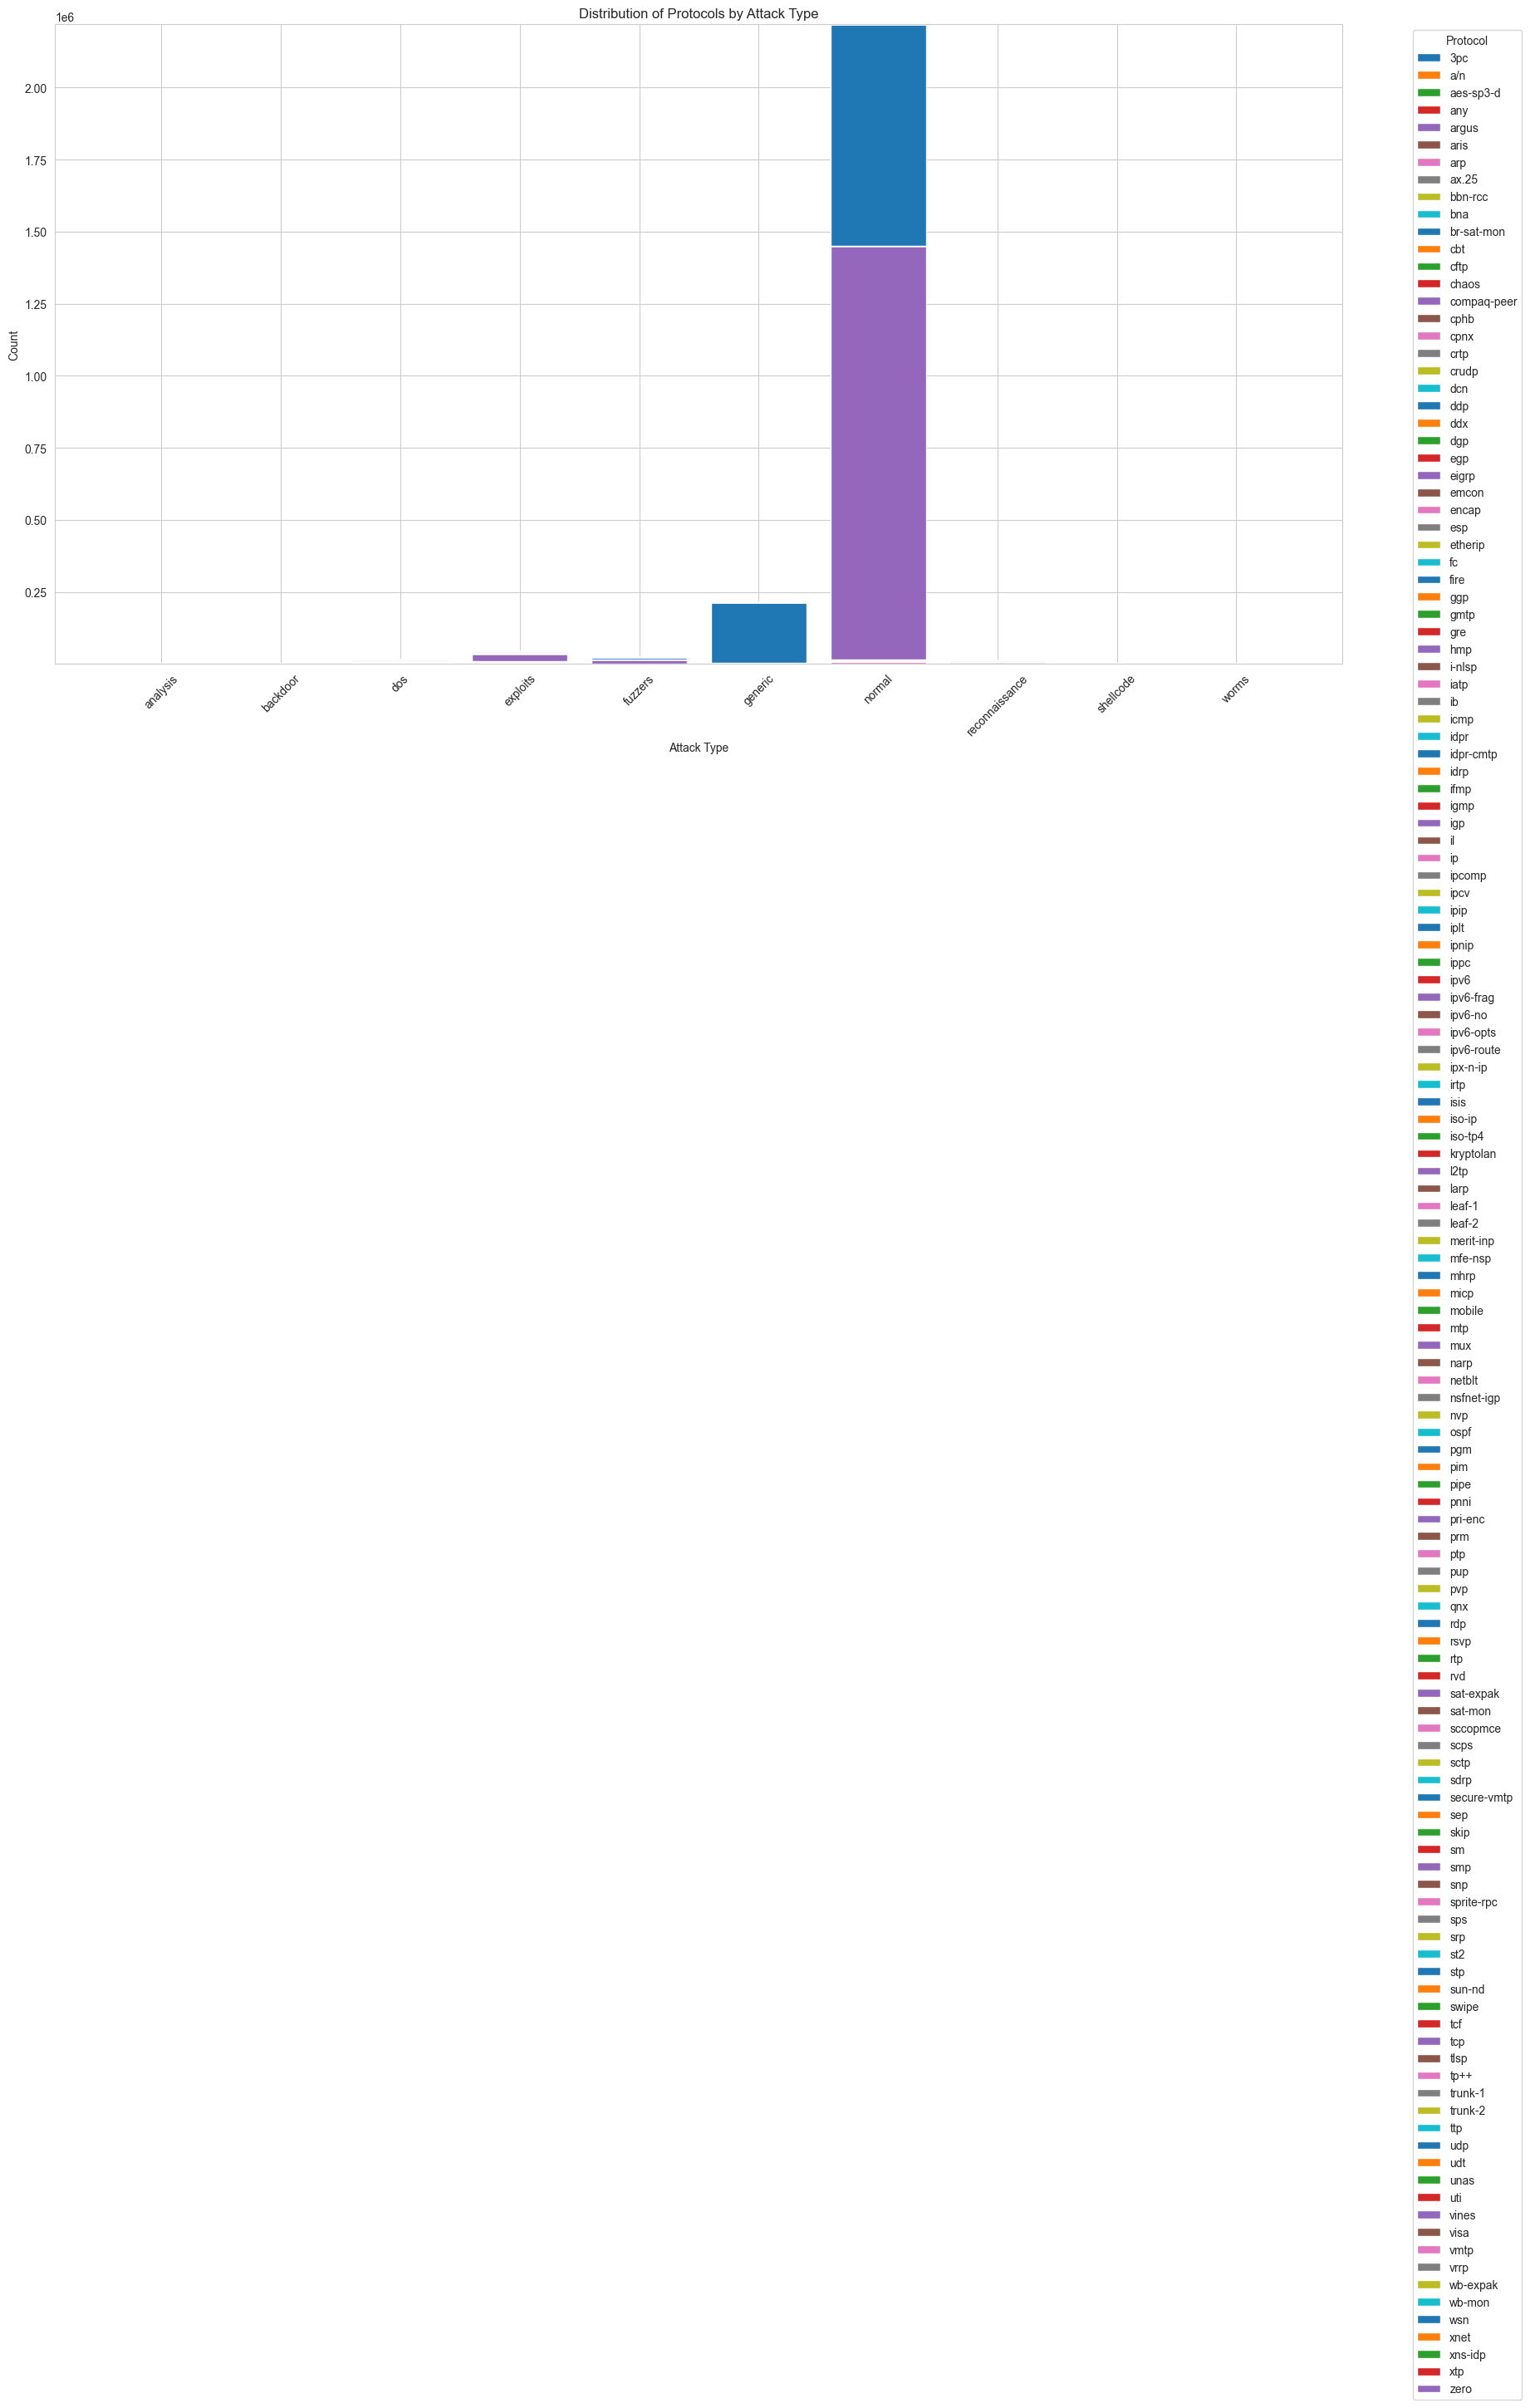

In [57]:
# Extract the protocol-attack relation again
protocol_attack_relation = train.groupby('proto')['attack_cat'].value_counts().unstack().fillna(0)

# Remove 'normal' column and filter out protocols that only have 'normal' traffic
protocol_attack_relation_filtered = protocol_attack_relation.drop(columns=['Normal'], errors='ignore')
protocol_attack_relation_filtered = protocol_attack_relation_filtered[protocol_attack_relation_filtered.sum(axis=1) > 0]

# Transpose the dataframe for plotting
protocol_attack_transposed = protocol_attack_relation_filtered.transpose()

# Create the plot
plt.figure(figsize=(20, 10))
ax = plt.subplot(111)
bottom = np.zeros(len(protocol_attack_transposed))

for column in protocol_attack_transposed.columns:
    ax.bar(protocol_attack_transposed.index, protocol_attack_transposed[column], label=column, bottom=bottom)
    bottom += protocol_attack_transposed[column]

plt.xticks(rotation=45)
plt.title("Distribution of Protocols by Attack Type")
plt.xlabel("Attack Type")
plt.ylabel("Count")
plt.legend(title="Protocol", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

La majorité des protocoles ont principalement du trafic normal.
Certains protocoles, tels que arp, présentent uniquement du trafic normal dans cet échantillon. D'autres protocoles, comme 3pc, ont des occurrences d'attaques de type dos. Le protocole tcp présente la plus grande diversité d'attaques.Certains protocoles, comme ospf, sctp, et sun-nd, ont des distributions d'attaques uniques qui diffèrent des autres.

## Matrice de corrélation
Pour vérifier la corrélation entre toutes les informations, retirer les doublons, épurer le nombre de colonnes

<Axes: xlabel='Name', ylabel='Name'>

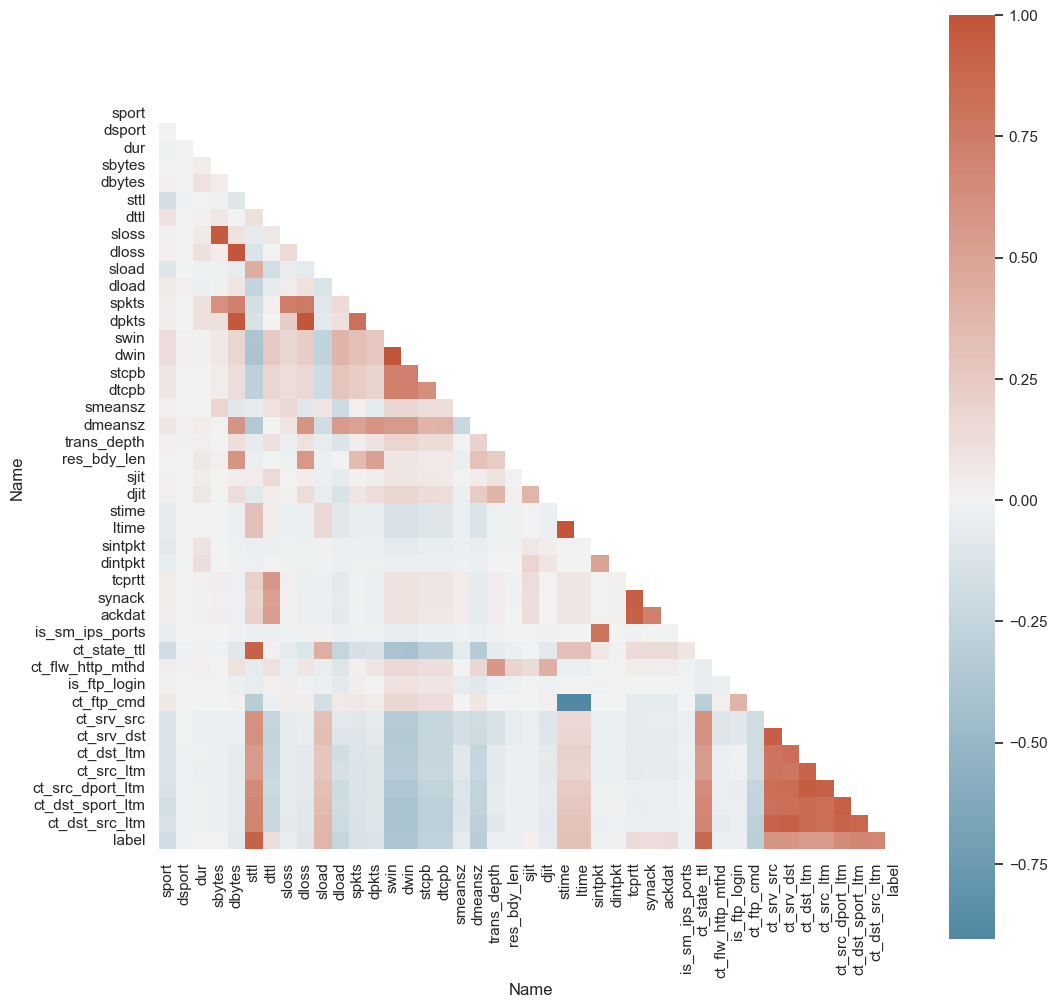

In [28]:
from string import ascii_letters

sns.set_theme(style="white")

# Calculer la matrice de corrélation
# Sélectionnez uniquement les colonnes numériques
numeric_cols = train.select_dtypes(include=[np.number])

# Calculer la matrice de corrélation
corr = numeric_cols.corr()

# Générer un masque pour le triangle supérieur qui n'est qu'une symétrie
mask = np.triu(np.ones_like(corr, dtype=bool))

# Mise en place de la figure matplotlib
f, ax = plt.subplots(figsize=(12,12))

# Générer une personnalisée "diverging colormap"
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Dessinez la carte thermique avec le masque et le bon rapport hauteur/largeur.
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, #vmax=.3,
            square=True) #, linewidths=.5, cbar_kws={"shrink": .5}

> La matrice de corrélation est une représentation des corrélations entre toutes les paires de colonnes de votre DataFrame. Plus la valeur de corrélation est proche de 1 (ou -1), plus les deux colonnes sont fortement corrélées (positivement ou négativement). Une corrélation proche de 0 indique une faible corrélation.





In [29]:
# Seuil de corrélation
seuil_corr = 0.9

# Identifiez les paires de colonnes corrélées
colonnes_corr = set()
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > seuil_corr:
            colonnes = corr.columns[i], corr.columns[j]
            colonnes_corr.add(colonnes)

# Affichez les paires de colonnes corrélées
print("Colonnes corrélées :")
for colonnes in colonnes_corr:
    print(colonnes)

Colonnes corrélées :
('ltime', 'stime')
('ct_ftp_cmd', 'stime')
('dloss', 'dbytes')
('ct_state_ttl', 'sttl')
('ct_src_ltm', 'ct_dst_ltm')
('sloss', 'sbytes')
('dpkts', 'dloss')
('synack', 'tcprtt')
('ct_dst_sport_ltm', 'ct_src_dport_ltm')
('ct_src_dport_ltm', 'ct_dst_ltm')
('ct_dst_src_ltm', 'ct_srv_src')
('dpkts', 'dbytes')
('dwin', 'swin')
('ackdat', 'tcprtt')
('label', 'sttl')
('ct_dst_src_ltm', 'ct_src_dport_ltm')
('ct_src_dport_ltm', 'ct_src_ltm')
('ct_srv_dst', 'ct_srv_src')
('ct_ftp_cmd', 'ltime')
('ct_dst_src_ltm', 'ct_srv_dst')


Les corrélations élevées suggèrent qu'il y a une redondance d'informations entre certaines paires de colonnes. Pour optimiser le sous-ensemble de colonnes, cette approche retire les colonnes qui ont des corrélations élevées, en ne conservant qu'une seule colonne de chaque paire.

In [30]:
# Affichez les valeurs de corrélation élevées
print("Valeurs de corrélation élevées :")
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > seuil_corr:
            print(f"{corr.columns[i]} - {corr.columns[j]} : {corr.iloc[i, j]}")

Valeurs de corrélation élevées :
sloss - sbytes : 0.9580513895313812
dloss - dbytes : 0.9914604923122531
dpkts - dbytes : 0.9710936205400174
dpkts - dloss : 0.9920582841895098
dwin - swin : 0.9971251868627908
ltime - stime : 0.9999999998771678
synack - tcprtt : 0.9307397076500592
ackdat - tcprtt : 0.9186306861666894
ct_state_ttl - sttl : 0.9160706074838167
ct_ftp_cmd - stime : -0.9051588103242791
ct_ftp_cmd - ltime : -0.9051587781844725
ct_srv_dst - ct_srv_src : 0.9335407219939044
ct_src_ltm - ct_dst_ltm : 0.9032453843577098
ct_src_dport_ltm - ct_dst_ltm : 0.9410575432751707
ct_src_dport_ltm - ct_src_ltm : 0.9195885292215679
ct_dst_sport_ltm - ct_src_dport_ltm : 0.9197162164347159
ct_dst_src_ltm - ct_srv_src : 0.908988731908519
ct_dst_src_ltm - ct_srv_dst : 0.9216394202512687
ct_dst_src_ltm - ct_src_dport_ltm : 0.9026623502020286
label - sttl : 0.9111707316256558


In [31]:
# Liste des colonnes fortement corrélées à retirer
colonnes_a_retirer = ['sbytes', 'dloss', 'dpkts', 'dwin', 'tcprtt', 'ct_srv_dst', 'ct_src_ltm', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm']
#Je laisse sttl dont la valeur de corrélation est la plus faible du tableau et ltime pour vérifier les décimales des durées.
# Créer un sous-dataframe avec les colonnes restantes
train = train.drop(colonnes_a_retirer, axis=1)

# Afficher les premières lignes du DataFrame optimisé
print(train.head())

Name       srcip  sport          dstip  dsport proto state       dur  dbytes  \
1     59.166.0.0  33661  149.171.126.9    1024   udp   CON  0.036133     304   
2     59.166.0.6   1464  149.171.126.7      53   udp   CON  0.001119     178   
3     59.166.0.5   3593  149.171.126.5      53   udp   CON  0.001209     164   
4     59.166.0.3  49664  149.171.126.0      53   udp   CON  0.001169     178   
5     59.166.0.0  32119  149.171.126.9     111   udp   CON  0.078339     312   

Name  sttl  dttl  ...  synack ackdat  is_sm_ips_ports  ct_state_ttl  \
1       31    29  ...     0.0    0.0                0             0   
2       31    29  ...     0.0    0.0                0             0   
3       31    29  ...     0.0    0.0                0             0   
4       31    29  ...     0.0    0.0                0             0   
5       31    29  ...     0.0    0.0                0             0   

Name  ct_flw_http_mthd  is_ftp_login  ct_ftp_cmd  ct_srv_src  attack_cat  \
1               

Attaques ciblées (Source-Destination IP et ports) :

Créez une carte de chaleur où l'axe horizontal représente la source IP (srcip), l'axe vertical représente la destination IP (dstip), et la couleur représente le nombre de connexions entre ces paires. Les couleurs plus intenses indiquent une fréquence plus élevée de connexions entre des paires spécifiques.

Utilisation d'outils polymorphes (Paquets et Taille moyenne des flux) :

Utilisez une carte de chaleur où l'axe horizontal représente le nombre de paquets (Spkts, Dpkts), l'axe vertical représente la taille moyenne des flux (smeansz, dmeansz), et la couleur représente la fréquence de ces combinaisons. Des zones avec des couleurs différentes pourraient indiquer des variations significatives.

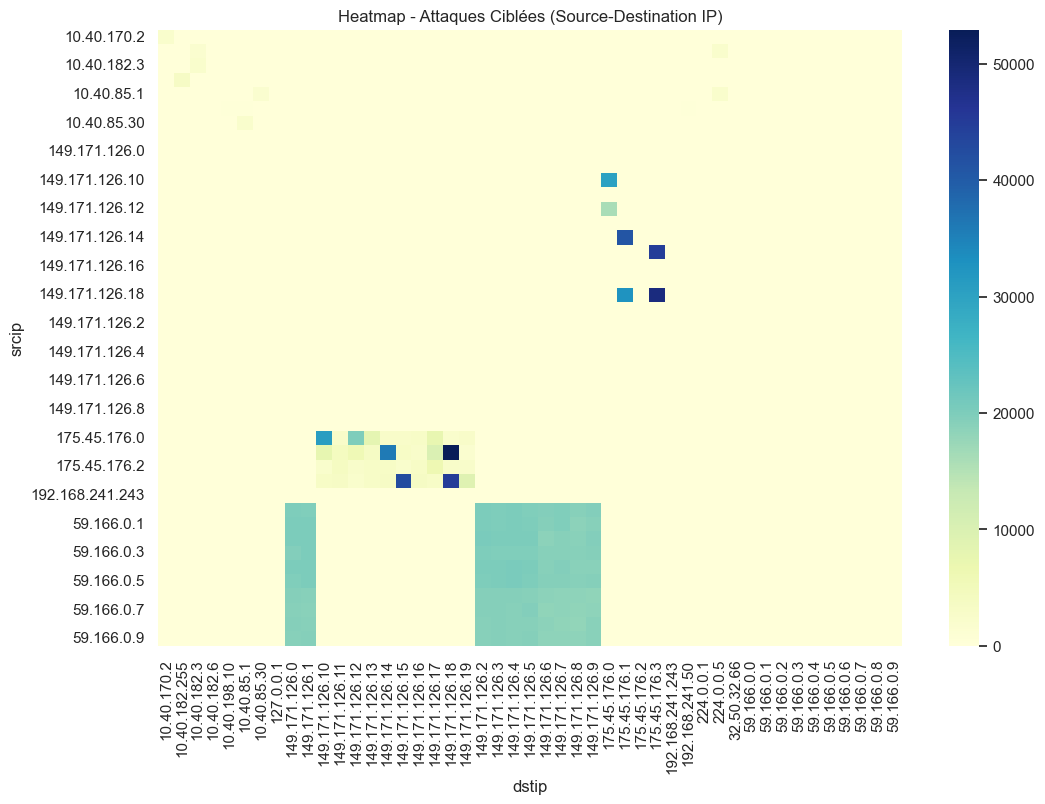

In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Attaques ciblées (Source-Destination IP et ports)
heatmap_data_cible = train.groupby(['srcip', 'dstip']).size().unstack(fill_value=0)
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_cible, cmap="YlGnBu")
plt.title('Heatmap - Attaques Ciblées (Source-Destination IP)')
plt.show()

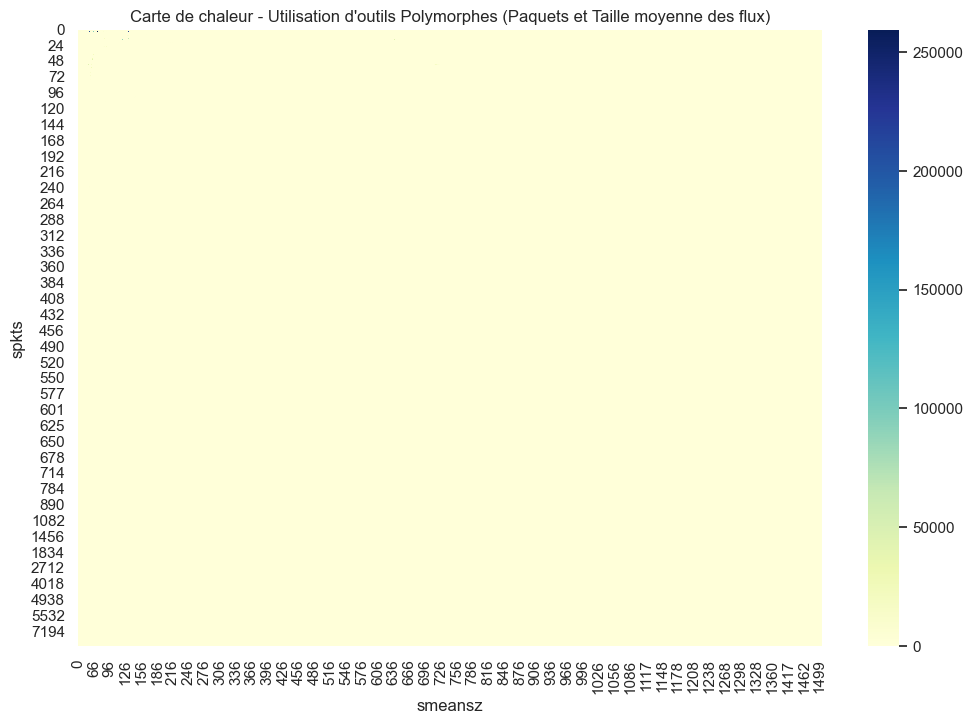

In [77]:
# Utilisation d'outils polymorphes (Paquets et Taille moyenne des flux)
heatmap_data_polymorphe = train.groupby(['spkts', 'smeansz']).size().unstack(fill_value=0)
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_polymorphe, cmap="YlGnBu")
plt.title('Carte de chaleur - Utilisation d\'outils Polymorphes (Paquets et Taille moyenne des flux)')
plt.show()

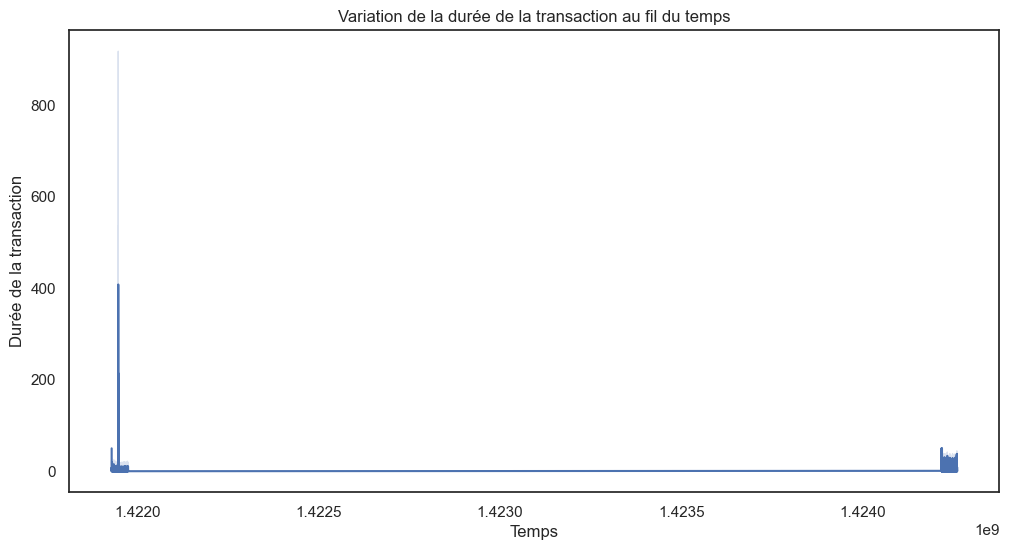

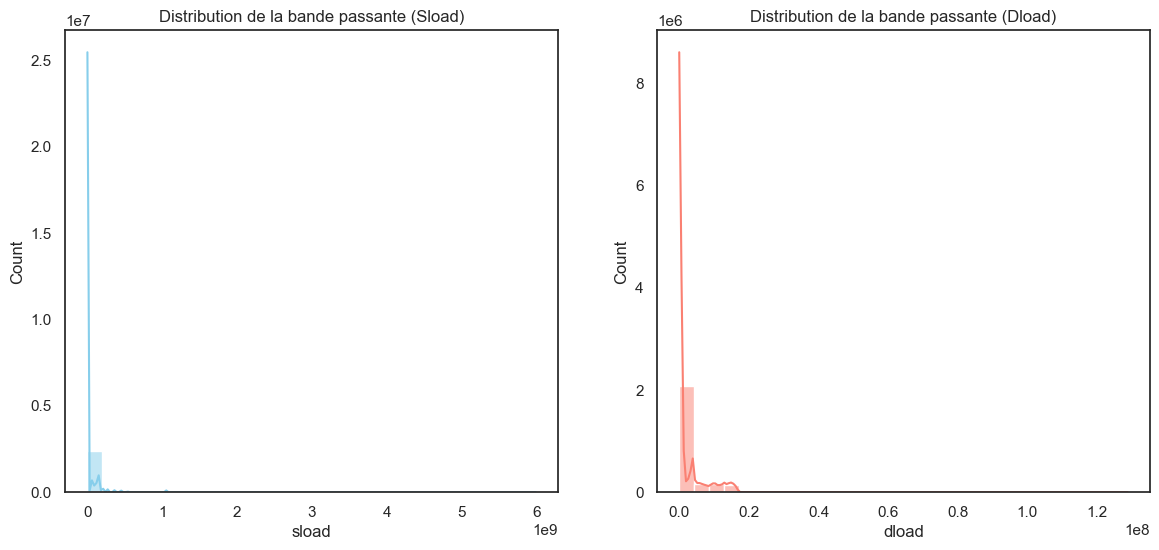

In [82]:
# Discrétion - Variation de la durée de la transaction au fil du temps (Graphique de ligne)
plt.figure(figsize=(12, 6))
sns.lineplot(x='stime', y='dur', data=train)
plt.title('Variation de la durée de la transaction au fil du temps')
plt.xlabel('Temps')
plt.ylabel('Durée de la transaction')
plt.show()


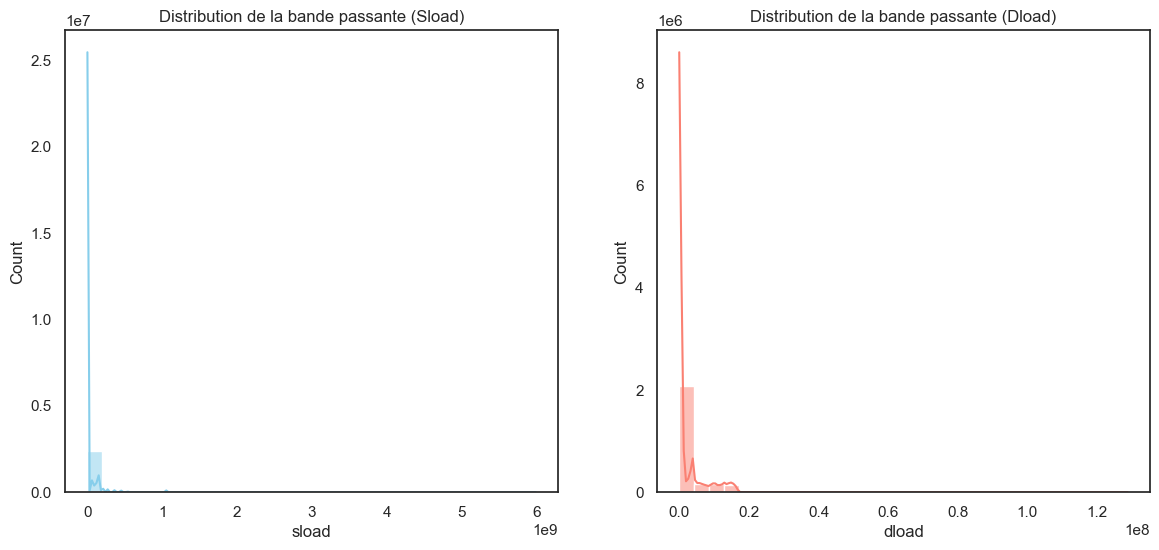

In [83]:
# Discrétion - Distribution de la bande passante (Histogrammes pour Sload et Dload)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(train['sload'], bins=30, kde=True, color='skyblue')
plt.title('Distribution de la bande passante (Sload)')

plt.subplot(1, 2, 2)
sns.histplot(train['dload'], bins=30, kde=True, color='salmon')
plt.title('Distribution de la bande passante (Dload)')

plt.show()

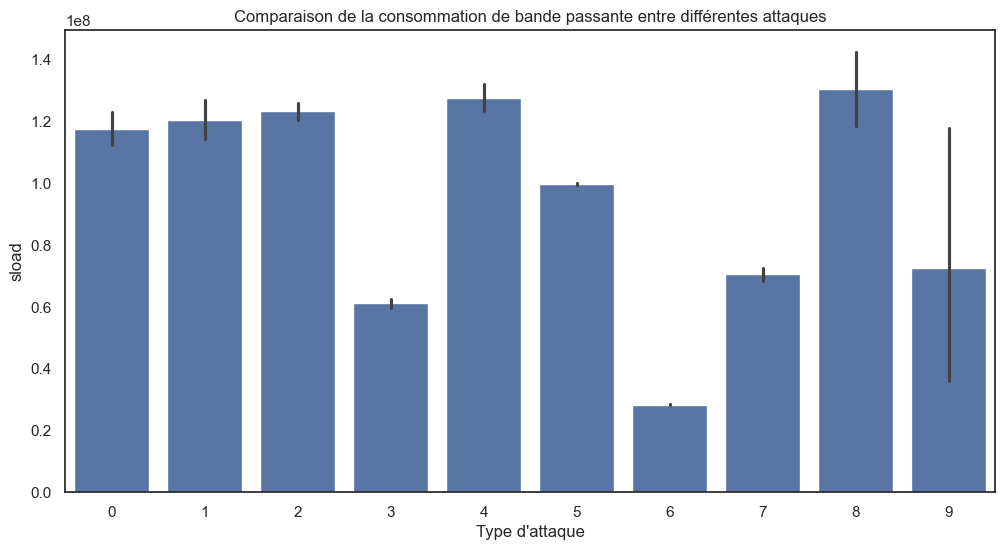

In [86]:
# Utilisation minimale des ressources - Comparaison de la consommation de bande passante entre différentes attaques (Diagramme à barres)
plt.figure(figsize=(12, 6))
sns.barplot(x='attack_cat', y='sload', data=train)
plt.title('Comparaison de la consommation de bande passante entre différentes attaques')
plt.xlabel("Type d'attaque")
plt.ylabel('sload')
plt.show()

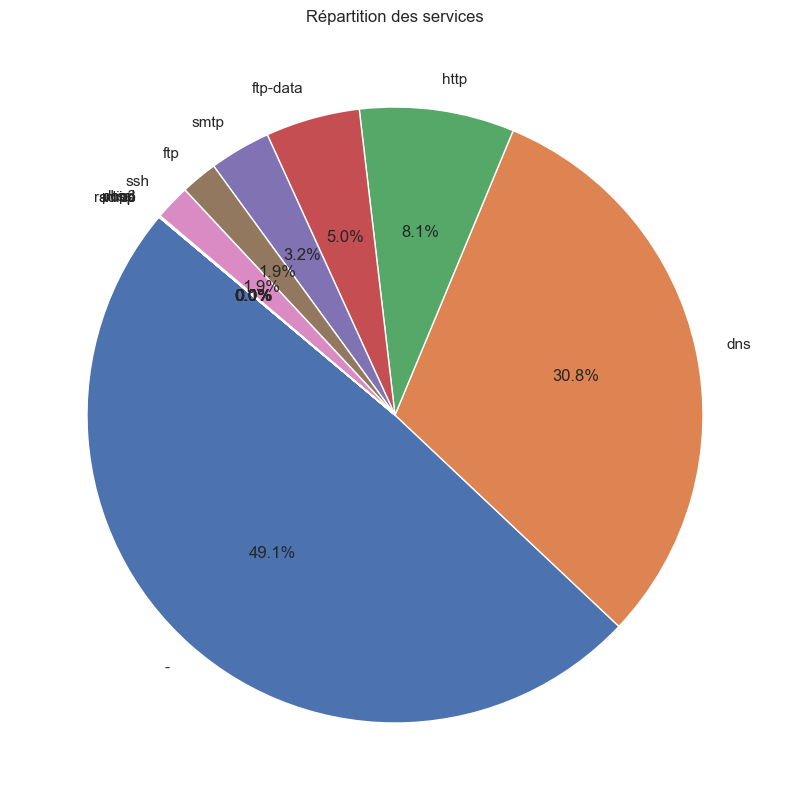

In [87]:
# Éviter les comportements suspects - Répartition des services (Diagramme à secteurs)
plt.figure(figsize=(10, 10))
service_distribution = train['service'].value_counts()
plt.pie(service_distribution, labels=service_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title('Répartition des services')
plt.show()

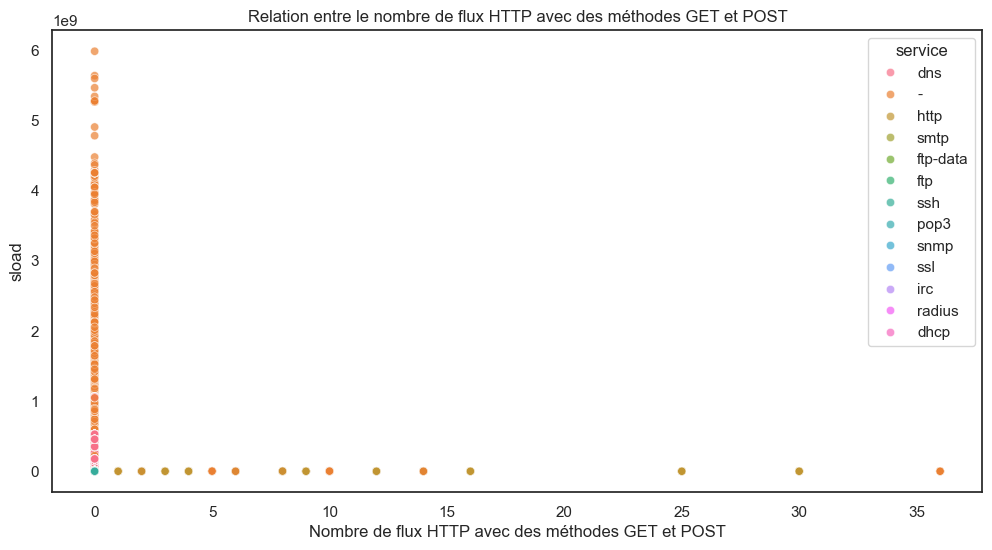

In [88]:
# Éviter les comportements suspects - Relation entre le nombre de flux HTTP avec des méthodes GET et POST (Graphique en nuage de points)
plt.figure(figsize=(12, 6))
sns.scatterplot(x='ct_flw_http_mthd', y='sload', data=train, hue='service', alpha=0.7)
plt.title('Relation entre le nombre de flux HTTP avec des méthodes GET et POST')
plt.xlabel('Nombre de flux HTTP avec des méthodes GET et POST')
plt.ylabel('sload')
plt.show()

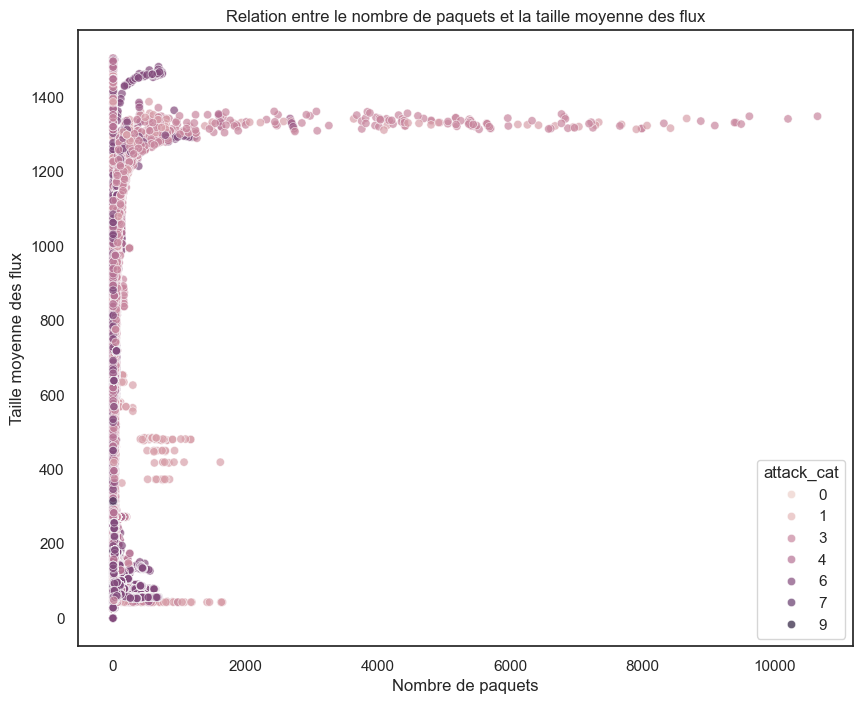

In [89]:
# Utilisation d'outils polymorphes - Relation entre le nombre de paquets et la taille moyenne des flux (Graphique de dispersion)
plt.figure(figsize=(10, 8))
sns.scatterplot(x='spkts', y='smeansz', data=train, hue='attack_cat', alpha=0.7)
plt.title('Relation entre le nombre de paquets et la taille moyenne des flux')
plt.xlabel('Nombre de paquets')
plt.ylabel('Taille moyenne des flux')
plt.show()

In [ ]:
'''# Division des données en ensembles d'entraînement et de test
X = data_ml.drop(columns='label')
y = data_ml['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape'''

# Prétraitement sans retirer 'attack_cat'
cols_to_drop = ['srcip', 'dstip']
data_ml = train.drop(columns=cols_to_drop)

# Définition du seuil
threshold = 0.9
# Encodage des variables catégorielles
label_encoders = {}
categorical_cols = data_ml.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    data_ml[col] = le.fit_transform(data_ml[col])
    label_encoders[col] = le

# Calcul de la matrice de corrélation
correlation_matrix = data_ml.drop(columns='label').corr()

# Identification des caractéristiques fortement corrélées
correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

correlated_features

La visualisation montre la distribution des différentes catégories d'attaques dans notre échantillon de données. La catégorie "normal" domine, ce qui signifie que la plupart des enregistrements correspondent à un trafic réseau normal.

## Recherche de l'adresse IP en fonction de l'attaque

In [ ]:
# Colonne 'srcip' et 'dstip' pour les adresses IP source et destination

# Obtenez les catégories uniques de 'attack_cat'
categories_uniques = train['attack_cat'].unique()

# Parcourez chaque catégorie et imprimez les adresses IP correspondantes
for categorie in categories_uniques:
    adresses_ip_source = train.loc[train['attack_cat'] == categorie, 'srcip'].unique()
    adresses_ip_destination = train.loc[train['attack_cat'] == categorie, 'dstip'].unique()
    nadresses_ip_source = train.loc[train['attack_cat'] == categorie, 'srcip'].nunique()
    nadresses_ip_destination = train.loc[train['attack_cat'] == categorie, 'dstip'].nunique()

    print(f'Catégorie: {categorie}')
    print(f'Adresses IP source: {adresses_ip_source}')
    print(f'Adresses IP destination: {adresses_ip_destination}')
    print(f'Nombre d\'adresses IP source uniques: {nadresses_ip_source}')
    print(f'Nombre d\'adresses IP destination uniques: {nadresses_ip_destination}')
    print('\n')

In [ ]:
# Filtrer les lignes où label est égal à 1
attaque_detectee = train[train['label'] == 1]

# Compter le nombre d'adresses IP source uniques
nombre_adresses_ip_source_uniques = attaque_detectee['srcip'].nunique()

# Compter le nombre d'adresses IP destination uniques
nombre_adresses_ip_destination_uniques = attaque_detectee['dstip'].nunique()

# Afficher les résultats
print(f"Nombre d'adresses IP source uniques lorsqu'une attaque est détectée : {nombre_adresses_ip_source_uniques}")
print(f"Nombre d'adresses IP destination uniques lorsqu'une attaque est détectée : {nombre_adresses_ip_destination_uniques}")

In [ ]:
import plotly.express as px

# Créez un DataFrame avec des catégories et les comptages correspondants
df_categories_counts = train_trie['Catégorie'].value_counts().reset_index()
df_categories_counts.columns = ['Catégorie', 'Comptage']

# Créez un diagramme Sunburst en utilisant le DataFrame des catégories
fig = px.sunburst(df_categories_counts, path=['Catégorie'], values='Comptage')

# Ajoutez un titre au diagramme
fig.update_layout(title="Répartition du nombre d'attaques par catégorie")

# Affichez le diagramme Sunburst
fig.show()

## Scatter Plot Matrix

In [ ]:
# Sélectionner un sous-ensemble de colonnes pour éviter un graphique trop encombré = résultat de la matrice de corrélation

# Créer le Scatter Plot Matrix
sns.pairplot(train, hue='label', markers=['o', 's'], palette='husl')



# Afficher le graphique
plt.show()

## Etude de la provenance des adresses IP
Trop onéreux ! Résultat non accessible

In [ ]:
#!pip install ip2geotools

In [ ]:
'''from ip2geotools.databases.noncommercial import DbIpCity

# Créez une nouvelle colonne pour stocker le pays
train['country'] = ""

# Itérez sur les adresses IP et recherchez le pays
for index, row in train.iterrows():
    ip_address = row['srcip']
    response = DbIpCity.get(ip_address, api_key='free')
    train.at[index, 'country'] = response.country

# Affichez le DataFrame avec la colonne 'country' mise à jour
print(train['country'])'''

In [ ]:
#!pip install geoip2

In [ ]:
'''import geoip2.database

# Chemin vers le fichier de base de données GeoIP (remplacez-le par votre propre chemin)
database_path = '/content/drive/MyDrive/path_to_your_database/GeoLite2-Country.mmdb'

# Adresse IP que vous souhaitez rechercher
ip_address = "8.8.8.8"  # Exemple avec l'adresse IP de Google

# Ouvrez la base de données
reader = geoip2.database.Reader(database_path)

# Recherchez le pays
response = reader.country(ip_address)

# Affichez le pays
print(f"Pays: {response.country.name}")'''

In [ ]:
'''# If you want to use synchronous requests
client = Client(10, 'LICENSEKEY');
# To query the GeoLite2 web service, you must set the "host" keyword argument
# to "geolite.info"
client = Client(10, 'LICENSEKEY', host='geolite.info');

# Or if you want to use asynchronous requests
async_client = AsyncClient(10, 'LICENSEKEY');

# To query the GeoLite2 web service, you must set the "host" keyword argument
# to "geolite.info"
async_client = AsyncClient(10, 'LICENSEKEY', host='geolite.info');

# Sync
import geoip2.webservice

with geoip2.webservice.Client(10, 'license_key') as client:
  # You can also use `client.city` or `client.insights`
  # `client.insights` is not available to GeoLite2 users
  response = client.country('128.101.101.101)

  print(response.country.iso_code)

# Async
import asyncio
import geoip2.webservice

async def main():
  async with geoip2.webservice.AsyncClient(10, 'license_key') as client:
    # You can also use `client.city` or `client.insights`
    # `client.insights` is not available to GeoLite2 users
    response = await client.country('128.101.101.101)

    print(response.country.iso_code)

asyncio.run(main())

                                    # Retrieve data for your IP address.
curl -u "{account_id}:{license_key}" \
  "https://geoip.maxmind.com/geoip/v2.1/country/me?pretty"

# Retrieve data for an arbitrary IP address.
curl -u "{account_id}:{license_key}" \
  "https://geoip.maxmind.com/geoip/v2.1/country/{ip_address}?pretty"'''